## Preparing Data and Variable Construction

In [1]:
# Import the modules
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from numpy.linalg import norm
from sklearn.linear_model import Ridge, Lasso
import math
import warnings
warnings.simplefilter("ignore")

In [2]:
# Import Data
df_monthly = pd.read_excel('PredictorData2018.xlsx', sheet_name="Monthly")

# Parse the dates properly
time = [str(d) for d in df_monthly.yyyymm]              # iterate through each date in series and form a list of strings of dates
df_monthly.index = pd.to_datetime(time,format="%Y%m")   # set dataframe index as constructed time list in year-month format

In [3]:
# Economic variable construction
df_monthly['ExRet'] = df_monthly['CRSP_SPvw']-df_monthly['Rfree']                # excess return/equity risk premium
df_monthly['DP'] = np.log(df_monthly['D12'])-np.log(df_monthly['Index'])         # dividend-price ratio (log)
df_monthly['DY'] = np.log(df_monthly['D12'])-np.log(df_monthly['Index'].shift()) # dividend-yield (log), lagged stock prices
df_monthly['EP'] = np.log(df_monthly['E12'])-np.log(df_monthly['Index'])         # earnings-price ratio (log)
df_monthly['DE'] = np.log(df_monthly['D12'])-np.log(df_monthly['E12'])           # dividend-payout ratio (log), dividend/earnings
df_monthly['tms'] = df_monthly['lty']-df_monthly['tbl']                          # term spread, difference between long-term yield and T-bill rate
df_monthly['dfr'] = df_monthly['corpr']-df_monthly['ltr']                        # long-term return, long-term gov bonds
df_monthly['dfy'] = df_monthly['BAA']-df_monthly['AAA']                          # default yield spread, corporate bond spread

df_monthly['PE'] = df_monthly['Index']/df_monthly['E12']
df_monthly['PE2'] = df_monthly['PE'].shift()                                     # create a new column with EP shifted down by one
df_monthly['Earnings'] = df_monthly['E12'].shift()                               # create a new column with Earnings shifted down by one

df_monthly['DP_n'] = (df_monthly['D12']/12)/df_monthly['Index']                       # SOP monthly dividend-price ratio (no log)
df_monthly['DP_SOP'] = np.log(1+df_monthly['DP_n'].shift())
df_monthly['PEG'] = np.log(df_monthly['PE'])-np.log(df_monthly['PE2'])                  # SOP earnings price multiple growth
df_monthly['EG'] = np.log(df_monthly['E12'])-np.log(df_monthly['Earnings'])             # SOP earnings growth

# Rename to avoid conflicts with patsy formula parsing
df_monthly['b2m'] = df_monthly['b/m']

# infl needs to be lagged one more month
df_monthly['infl'] = df_monthly['infl'].shift()                           # CPI is a lagging indicator, shifted for use in previous month estimation


# Technical variable construction
n = len(df_monthly)

# Lag S&P500 index by different months
for i in range(1,13):
    df_monthly[str(i)+'mon'] = df_monthly['Index'].shift(i-1, axis=0)

# Short-term (s:1,2,3) and long-term (l:9,12) moving averages of S&P500
for i in [1, 2, 3, 9, 12]:
    df_monthly[str(i)+'m_MA'] = np.sum(df_monthly[[str(x)+'mon' for x in range(1,i+1)]], axis=1)/i

# Lag OBV (“on-balance” volume) by different months
for i in range(1,13):
    df_monthly[str(i)+'mon_OBV'] = df_monthly['OBV'].shift(i-1, axis=0)

# Short-term (s:1,2,3) and long-term (l:9,12) moving averages of OBV
for i in [1, 2, 3, 9, 12]:
    df_monthly[str(i)+'m_VOL'] = np.sum(df_monthly[[str(x)+'mon_OBV' for x in range(1,i+1)]], axis=1)/i

# Technical Trading Rules
# Moving-average rules: =1 if SMA > LMA and =0 otherwise
for i in [1, 2, 3]:
    for j in [9, 12]:
        df_monthly['MA'+str(i)+'_'+str(j)] = np.zeros(n)
        for k in range(n):
            df_monthly['MA'+str(i)+'_'+str(j)][k] = 1 if df_monthly[str(i)+'m_MA'][k] >= df_monthly[str(j)+'m_MA'][k] else 0

# Momentum rules: =1 if current S&P500 index > index (m:9,12) months ago and =0 otherwise
for i in [9, 12]:
    df_monthly['MOM1_'+str(i)] = np.zeros(n)
    for k in range(n):
        df_monthly['MOM1_'+str(i)][k] = 1 if df_monthly['Index'][k] >= df_monthly[str(i)+'mon'][k] else 0

# Volume rules: =1 if OBV SMA > OBV LMA and =0 otherwise; volume is zero before 1950-01-01
for i in [1, 2, 3]:
    for j in [9, 12]:
        df_monthly['VOL'+str(i)+'_'+str(j)] = np.zeros(n)
        for k in range(n):
            df_monthly['VOL'+str(i)+'_'+str(j)][k] = 1 if df_monthly[str(i)+'m_VOL'][k] >= df_monthly[str(j)+'m_VOL'][k] else 0
            

# Construction of dependent and independent variables and create a dataframe to store variables of interest
dep_var = 'ExRet'
indep_vars_econ = ['DE','svar','dfr','lty','ltr','infl','tms','tbl','dfy','DP','DY','EP','b2m','ntis']
indep_vars_tech = ['MA1_9','MA1_12','MA2_9','MA2_12','MA3_9','MA3_12','MOM1_9','MOM1_12','VOL1_9','VOL1_12','VOL2_9','VOL2_12','VOL3_9','VOL3_12']
indep_vars = indep_vars_econ + indep_vars_tech


# Use the data from 1951/01 to 2018/12
# index returns (CRSP_SPvw and ExRet), stock variance (svar), corporate issuing activity (ntis) not available before 1926
# OBV data not available before 1950, need at least 12 months from first data point for technical indicators
subperiod = df_monthly.index>='1950-01-01'
df = df_monthly[subperiod]                                         # all variables in the dataset
M = 240                                                            # Initial length of estimation window, enough initial data for a reliable regression estimate at start 
gam = 3                                                            # risk aversion coefficient, Brennan and Xia (2004), Campbell and Thompson (2005)

# Create the benchmark using historical average
Hist_Mean = np.asarray(df[dep_var].expanding().mean().shift())     # expanding recursive window for sample historical mean, shift to directly compare with next period forecast -> forecast error
Hist_Variance = np.asarray(df[dep_var].expanding().var().shift())  # expanding recursive window for sample historical variance, shift to directly compare with next period forecast -> change in CEV

# Benchmark SSE (Historical Average)
OOS_SSE_Hist = np.sum((df[dep_var][M+1:]-Hist_Mean[M+1:])**2)      # sum of squared total (H0: intercept model) $$\sum_{t=M+1}^{T}{\hat{e}}_{0,t}^2$$

# Benchmark Certainty Equivalence
w0 = ((1/gam)*(Hist_Mean/Hist_Variance)).clip(None,1.5);           # estimated mean-variance optimal weight in market portfolio, max 150% (margin requirements)
r0 = df[dep_var]*w0                                                # portfolio excess return = optimal weight(estimated from last period) * market excess return
CE_Hist = np.mean(r0[M+1:])-gam/2*np.var(r0[M+1:],ddof=1)          # investor certainty equivalence, estimated using OOS average portfolio excess return and sample portfolio variance


df[[dep_var] + indep_vars_econ + indep_vars_tech].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ExRet,828.0,0.006238,0.041386,-0.220903,-0.018156,0.009072,0.032780,0.161896
DE,828.0,-0.731393,0.289587,-1.244209,-0.898515,-0.710490,-0.586113,1.379530
svar,828.0,0.001934,0.004000,0.000072,0.000606,0.001036,0.002003,0.070945
dfr,828.0,0.000248,0.013922,-0.097500,-0.005425,0.000700,0.005900,0.073700
lty,828.0,0.058965,0.027789,0.017500,0.038156,0.053500,0.077525,0.148200
ltr,828.0,0.005162,0.027389,-0.112400,-0.009325,0.002750,0.020225,0.152300
infl,828.0,0.002861,0.003625,-0.019153,0.000000,0.002852,0.004867,0.018059
tms,828.0,0.016929,0.013762,-0.036500,0.007500,0.015800,0.027800,0.045500
tbl,828.0,0.042037,0.030814,0.000100,0.017175,0.039300,0.057150,0.163000
dfy,828.0,0.009556,0.004353,0.003200,0.006800,0.008400,0.011325,0.033800


In [4]:
# The difference between ExRet and SOP decomposition is small - SOP is a valid decomposition
np.linalg.norm(np.asarray(df_monthly['ExRet'])[660:] - np.asarray(df_monthly['PEG'] + df_monthly['EG'] + df_monthly['DP_SOP'] - df_monthly['Rfree'])[660:])

0.19784982941612364

## OLS Forecast of Economic Variables on Equity Premium

In [5]:
# Define the function to calculate the fitted value from recursive OLS
def pred_from_OLS(X, Y, M):
    """Compute the next period predicted value based on recursive OLS regression.    
    Args:
        X : The independant variables
        Y : The dependant variable
        M : Initial length of estimation window for out-of-sample tests
    Returns:
        Y_hat: The predicted value based on expanding windows
    """     
    Y_Hat = np.full(len(Y), np.nan)
    Y = np.asarray(Y)
    X = np.asarray(X)
    X = sm.add_constant(X)
    # Note that we start the index at M+1 because the first element of predicted return is at t=M+2.
    for i in range(M+1,len(Y)):
        Y1 = Y[1:i]
        X1 = X[0:i-1,:] 
        reg = sm.OLS(Y1,X1,missing='drop').fit()
        Y_Hat[i] = reg.predict(X[i-1,:])             # The predicted return is based on the observation of the predictor before
    return Y_Hat

In [6]:
# Define the function to compute two out-of-sample measures of performance
def oos_eval(Y, Pred_Mean): # input are DataFrame Series
    """This function computes OOS R^2 and CEV based on a vector of predicted mean and variance
    Args:
        Y: The excess returns
        Pred_Mean: The time series of predicted mean
    Returns:
        OOS_R2: Out-of-sample R^2
        CE: certainty equivalence of the out-of-sample return
    """
    Pred_Mean = np.asarray(Pred_Mean)
    
    Hist_Mean = np.asarray(Y.expanding().mean().shift())     # expanding recursive window for sample historical mean, shift to directly compare with next period forecast -> forecast error
    Hist_Variance = np.asarray(Y.expanding().var().shift())
    
    OOS_SSE_Hist = np.sum((Y[M+1:]-Hist_Mean[M+1:])**2)
    OOS_SSE = np.sum((Y[M+1:]-Pred_Mean[M+1:])**2)
    
    OOS_R2 = 1-OOS_SSE/OOS_SSE_Hist
    w0 = ((1/gam)*(Pred_Mean/Hist_Variance)).clip(None,1.5)
    r0 = Y*w0
    CE = np.mean(r0[M+1:])-gam/2*np.var(r0[M+1:],ddof=1)
    dRMSE = np.sqrt(OOS_SSE_Hist) - np.sqrt(OOS_SSE)
    
    return OOS_R2, CE, dRMSE

In [7]:
# Create the table for in-sample R^2, out-of-sample R^2 and certainty equivlance
def GW(X, Y, Y_Hat):    
    """Compute the in-sample and out-of-sample statistics of predictive regressions 
    Args:
        X: The independent variables
        Y : The dependant variable
        Y_Hat: The vector of predicted expected returns based on expanding windows
    Returns:
        data: a dataframe of the statistics of in-sample and out-of-sample tests
    """
    # Create the benchmark using historical average
    X = np.asarray(X)
    X = sm.add_constant(X)  
   
    # I. In sample
    Y_1 = Y[1:]
    X_1 = X[0:len(Y)-1]
    reg = sm.OLS(Y_1, X_1, missing='drop').fit()
    
    # I.1 In-sample R^2 for OLS Model (non truncated)
    IS_R2 = reg.rsquared
        
    # I.2 In-sample R^2 for OLS Model (truncated)
    y1 = Y_1-np.mean(Y_1)
    e1 = Y_1-reg.predict(X_1).clip(0,None)
    IS_R2_T = 1-np.sum(e1**2)/np.sum(y1**2)
    
    # I.3 Historical mean model
    avg = Y.mean()
    IS_Error_Mean = Y - avg
    IS_Error_OLS = reg.resid
    
    # II. Out of sample    
    # II.1 Forecast based on regression with expanding window                
    OOS_R2, CE, dRMSE = oos_eval(Y, Y_Hat)
    
    # II.2 Trunacated forecast based on regression with expanding window
    OOS_R2_T, CE_T, dRMSE_T = oos_eval(Y, Y_Hat.clip(0,None))
    
    # Return the table
    data = pd.DataFrame({'$R_{IS}^2$':IS_R2,'$R^2_{IS}$ (Truncated)':IS_R2_T,'$R^2_{OS}$':OOS_R2, 
                         '$R^2_{OS}$ (Truncated)':OOS_R2_T,'$\Delta CEV$':CE-CE_Hist,
                         '$\Delta CEV$ (Truncated)': CE_T-CE_Hist,'$\Delta RMSE$': dRMSE,
                         '$\Delta RMSE$ (Truncated)': dRMSE_T},index=[indep_var])*100
    return data

In [8]:
# Create a prediction matrix from different predictive regressions
# Multiple predictive regression using all predictive variables excluding DE and tms
df_pred_econ = pd.DataFrame(pred_from_OLS(df[[x for x in indep_vars_econ if x not in('DE','tms')]], df[dep_var], M))
df_pred_econ.columns = ['All']
# Simple predictive regressions using one predictive variable at a time
for indep_var in tqdm(indep_vars_econ):
    df_pred_econ[indep_var] = pred_from_OLS(df[indep_var], df[dep_var], M)

100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


In [9]:
# Create the Table for the in- and out-of-sample performance
pd.options.display.float_format = '{:.3f}'.format
# Get rid of d/e and tms to avoid perfect multicollinearity
data = GW(df[[x for x in indep_vars_econ if x not in('DE','tms')]], df[dep_var], df_pred_econ['All']) 
data.rename(index={data.index[0]:'All'},inplace=True) 
for indep_var in indep_vars_econ:
    x = GW(df[indep_var], df[dep_var], df_pred_econ[indep_var])
    data = data.append(x)    
data

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
All,6.365,4.253,-2.504,-0.944,-1.418,0.302,-1.314,-0.497
DE,0.104,0.104,-0.868,-0.322,-0.429,-0.040,-0.457,-0.170
svar,1.067,-0.139,-0.195,-0.295,-0.218,0.051,-0.103,-0.156
dfr,0.206,0.061,-0.581,-0.509,0.017,0.039,-0.306,-0.269
lty,0.377,0.360,-1.760,0.127,-0.809,0.073,-0.925,0.067
ltr,0.839,0.748,0.351,0.285,0.211,0.196,0.185,0.150
infl,0.011,0.011,-0.426,-0.229,-0.037,0.044,-0.225,-0.121
tms,0.476,0.480,-1.537,-1.482,0.186,0.215,-0.809,-0.780
tbl,0.742,0.632,-1.693,-0.220,-0.761,0.103,-0.890,-0.116
dfy,0.030,0.030,-0.658,-0.658,-0.083,-0.083,-0.347,-0.347


## OLS Forecast of Economic and Technical Variables on Equity Premium

In [10]:
# Create a prediction matrix from different predictive regressions
# Multiple predictive regression using all predictive variables excluding DE and tms
df_pred_all = pd.DataFrame(pred_from_OLS(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], M))
df_pred_all.columns = ['All']
# Simple predictive regressions using one predictive variable at a time
for indep_var in tqdm(indep_vars):
    df_pred_all[indep_var] = pred_from_OLS(df[indep_var], df[dep_var], M)

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


In [11]:
# Create the Table for the in- and out-of-sample performance
pd.options.display.float_format = '{:.3f}'.format
# Get rid of d/e and tms to avoid perfect multicollinearity
data = GW(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], df_pred_all['All']) 
data.rename(index={data.index[0]:'All'},inplace=True) 
for indep_var in indep_vars:
    x = GW(df[indep_var], df[dep_var], df_pred_all[indep_var])
    data = data.append(x)    
data

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
All,8.576,5.067,-3.564,-1.304,-1.510,0.306,-1.865,-0.686
DE,0.104,0.104,-0.868,-0.322,-0.429,-0.040,-0.457,-0.170
svar,1.067,-0.139,-0.195,-0.295,-0.218,0.051,-0.103,-0.156
dfr,0.206,0.061,-0.581,-0.509,0.017,0.039,-0.306,-0.269
lty,0.377,0.360,-1.760,0.127,-0.809,0.073,-0.925,0.067
ltr,0.839,0.748,0.351,0.285,0.211,0.196,0.185,0.150
infl,0.011,0.011,-0.426,-0.229,-0.037,0.044,-0.225,-0.121
tms,0.476,0.480,-1.537,-1.482,0.186,0.215,-0.809,-0.780
tbl,0.742,0.632,-1.693,-0.220,-0.761,0.103,-0.890,-0.116
dfy,0.030,0.030,-0.658,-0.658,-0.083,-0.083,-0.347,-0.347


### Plotting of Economic and Technical Variables on Equity Premium

In [12]:
def plot_pred_OLS(x, dep_var, indep_var, window):
    """Compute the next period predicted value for univariate
    OLS regression.
    
    Note: 
        The x dataframe must contain dep_var, indep_var
        and the lagged indep_var.

    Args:
        x : The dataframe to use for computation
        dep_var : The dependant variable
        indep_var : The independant variable
        window : The minimum window length
    
    Returns:
        The predicted value or nan if data shorter than window.
    """
    if x[[dep_var, indep_var + '_lag']].notnull().all(axis=1).sum() < window:
        return np.nan
    res = smf.ols(dep_var + ' ~ ' + indep_var + '_lag', data=x).fit()
    indep_var_t = x[indep_var].iloc[-1]
    return res.predict([1,indep_var_t],transform=False)

In [13]:
def GW_cum_sse(df, indep_var, dep_var, window):    
    """Compute the in-sample and out-of-sample predictability
    statistics required to reproduce the plots from 
    Goyal & Welch (2008).
    
    Note: 
        The df dataframe must contain dep_var and indep_var.

    Args:
        df : The dataframe to use for computation
        dep_var : The dependant variable
        indep_var : The independant variable
        window : The minimum window length
    
    Returns:
        The indput dataframe augmented with additional columns.
    """
    # Make sure we don't modify the input
    df = df.copy()
    
    df[indep_var + '_lag'] = df[indep_var].shift()
    
    # I. In sample
    # I.1 Historical mean model
    avg = df[dep_var].mean()
    df['IS_Error_Mean'] = df[dep_var] - avg
    
    # I.2 OLS Model
    res = smf.ols(dep_var + ' ~ ' + indep_var + '_lag', data=df).fit()
    df['IS_Error_OLS'] = res.resid 
    
    # II. Out of sample
    # II.1 Historical mean model
    df['OOS_Pred_Mean'] = df.expanding(min_periods=window)[dep_var].mean().shift()
    df['OOS_Error_Mean'] = df[dep_var] - df['OOS_Pred_Mean']
    
    # II.2 OLS
    # Home-made expanding window because pandas doesn't yet support axis=1 on
    # apply with expanding.
    df['OOS_Pred_OLS_1'] = np.nan
    for i in range(window,len(df)):
        df['OOS_Pred_OLS_1'].iloc[i] = plot_pred_OLS(df.iloc[0:i+1], dep_var, indep_var, window)
    df['OOS_Pred_OLS'] = df['OOS_Pred_OLS_1'].shift()
    del df['OOS_Pred_OLS_1']
    df['OOS_Error_OLS'] = df[dep_var] - df['OOS_Pred_OLS']
    
    # Cumulative SSE differences
    df['IS_SSE'] = ((df['IS_Error_Mean'] ** 2).cumsum() - (df['IS_Error_OLS'] ** 2).cumsum())
    df['OOS_SSE'] = ((df['OOS_Error_Mean'] ** 2).cumsum() - (df['OOS_Error_OLS'] ** 2).cumsum())
    
    return df

In [14]:
def plot_cum_sse(sse_df, ax, title="", ylim=(-0.22, 0.22),
                 xlim=(datetime(1890, 1, 1), datetime(2010, 1, 1)),
                 add_oil_shock=False, add_GFC=False, shade_outside_scale=None):
    out = sse_df.copy()
    # Pad with a zero the obs before the first OOS observation
    idx = out['OOS_SSE'].dropna().index[0]
    idx = out[:idx].index[-2]
    out.loc[out.index == idx, 'OOS_SSE'] = 0.0
    
    # Normalize to 0 at the first OOS observation
    t0 = sse_df[['IS_SSE','OOS_SSE']].dropna().iloc[0]
    sse_df['IS_SSE_norm'] = sse_df['IS_SSE'] - t0['IS_SSE']
    sse_df['OOS_SSE_norm'] = sse_df['OOS_SSE'] - t0['OOS_SSE']
    
    # Plot the two series
    sse_df['IS_SSE_norm'].plot(ax=ax, color='black', linestyle=':')
    sse_df['OOS_SSE_norm'].plot(ax=ax, color='black',
                                linestyle='-', linewidth=1.5)

    # Add legends to the graph
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(loc='upper right', bbox_to_anchor=(0.5, 0.25) )
        
    # Add square around first obs.
    ax.scatter(t0.name, 0.0, marker='s', facecolor='none', edgecolor='k')
    # Add vertical line at first obs.
    ax.axvline(x=t0.name, ymin=(-0.06 - ylim[0]) / (ylim[1] - ylim[0]),
               color='k', linestyle='-',  linewidth=1, alpha=0.5)
    
    # Add other decorations
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Cumulative SSE Difference')
    ax.axvline(x=t0.name, ymin=(-0.06 - ylim[0]) / (ylim[1] - ylim[0]),
               color='k', linestyle='-',  linewidth=1, alpha=0.5)
    if add_oil_shock:
        ax.fill_between([datetime(1973,1,1), datetime(1975,1,1)], ylim[0], ylim[1],
                        facecolor='pink', alpha=0.25)
    
    if add_GFC:
        ax.fill_between([datetime(2007,8,1), datetime(2009,3,1)], ylim[0], ylim[1],
                        facecolor='red', alpha=0.25)    
    
    # Add the shaded area to indicate the "normal" scale.
    if shade_outside_scale is not None:
        ax.axhline(y=shade_outside_scale[1], color='k', linestyle='-',
                   linewidth=0.5, alpha=0.5)
        ax.fill_between(xlim, shade_outside_scale[1], ylim[1],
                        facecolor='black', alpha=0.1)
        ax.axhline(y=shade_outside_scale[0], color='k', linestyle='-',
                   linewidth=0.5, alpha=0.5)
        ax.fill_between(xlim, ylim[0], shade_outside_scale[0],
                        facecolor='black', alpha=0.1)

In [15]:
# Define labels for plots
var_labels = {'CRSP_SPvw': 'S\\&P500 Returns',
              'ExRet': 'Equity Premium',
              'ExRetRS': 'Equity Premium (Shiller)',
              'Ret': 'Market Return',
              'Rfree': 'Risk-free rate',
              'D12': 'S\\&P500 Dividends (last 12 months)',
              'DP': 'Dividend Price Ratio $(d/p)$',
              'DY': 'Dividend Yield $(d/y)$',
              'E12': 'S\\&P500 earnings (last 12 months)',
              'E_10m': 'S\\&P500 earnings (annual, 10 years moving avg.)',
              'EP': 'Earnings Price Ratio $(e/p)$',
              'E10P': 'Earnings Price Ratio $(e^{10}/p)$',
              'DE': 'Dividend Payout Ratio $(d/e)$',
              'svar': 'Stock Variance $(svar)$',
              'csp': 'Cross-Sectionnal Premium $(csp)$',
              'b2m': 'Book-to-Market Ratio $(b/m)$',
              'ntis': 'Net Equity Expansion $(ntis)$',
              'eqis': 'Percent Equity Issuing $(eqis)$',
              'tbl': 'Treasury Bills $(tbl)$',
              'lty': 'Long Term Yield $(lty)$',
              'ltr': 'Long Term Rate $(ltr)$',
              'tms': 'Term Spread $(tms)$',
              'dfy': 'Default Yield $(dfy)$',
              'dfr': 'Default Return Spread $(dfr)$',
              'infl': 'Inflation $(infl)$',
              'ik': 'Investment to Capital Ratio $(i/k)$',
              'cay': 'Consumption, wealth, income ratio $(cay)$',
              'MA1_9': 'MA Rules: SMA(1) vs LMA(9)',
              'MA1_12': 'MA Rules: SMA(1) vs LMA(12)',
              'MA2_9': 'MA Rules: SMA(2) vs LMA(9)',
              'MA2_12': 'MA Rules: SMA(2) vs LMA(12)',
              'MA3_9': 'MA Rules: SMA(3) vs LMA(9)',
              'MA3_12': 'MA Rules: SMA(3) vs LMA(12)',
              'MOM1_9': 'Momentum Rules: S\\&P500(1) vs S\\&P500(9)',
              'MOM1_12': 'Momentum Rules: S\\&P500(1) vs S\\&P500(12)',
              'VOL1_9': 'Volume Rules: OBV SMA(1) vs OBV LMA(9)',
              'VOL1_12': 'Volume Rules: OBV SMA(1) vs OBV LMA(12)',
              'VOL2_9': 'Volume Rules: OBV SMA(2) vs OBV LMA(9)',
              'VOL2_12': 'Volume Rules: OBV SMA(2) vs OBV LMA(12)',
              'VOL3_9': 'Volume Rules: OBV SMA(3) vs OBV LMA(9)',
              'VOL3_12': 'Volume Rules: OBV SMA(3) vs OBV LMA(12)'
              }

In [16]:
def plot_vars(dep_var, indep_vars, ymin, ymax):
    
    dfplot = df_monthly[[dep_var] + indep_vars]
    
    if len(indep_vars)%4 == 0:
        a,b = 7, math.ceil(len(indep_vars)/7)
        fig, axes = plt.subplots(a, b, figsize=(35, 25), dpi=80)
    else:
        a,b = 5, math.ceil(len(indep_vars)/5)
        fig, axes = plt.subplots(a, b, figsize=(20, 16), dpi=80)
                
    for i in tqdm(range(a)):
        for j in range(b):
            idx = i*b + j
            ax = axes[i][j]
            if idx < len(indep_vars):
                indep_var = indep_vars[idx]
                out = GW_cum_sse(dfplot['1950-01-01':], indep_var,
                             dep_var, window=20*12)
                plot_cum_sse(out, ax, title=var_labels[indep_var],
                             add_oil_shock=True,
                             add_GFC=True,
                             xlim=datetime(1950, 1, 1),
                             ylim=(ymin, ymax))
            else:
                ax.set_visible(False)

    fig.tight_layout()
    
    fig.savefig(dep_var+'_Monthly_CumSSEDiff.pdf', dpi=1000)

100%|██████████| 7/7 [02:46<00:00, 23.79s/it]


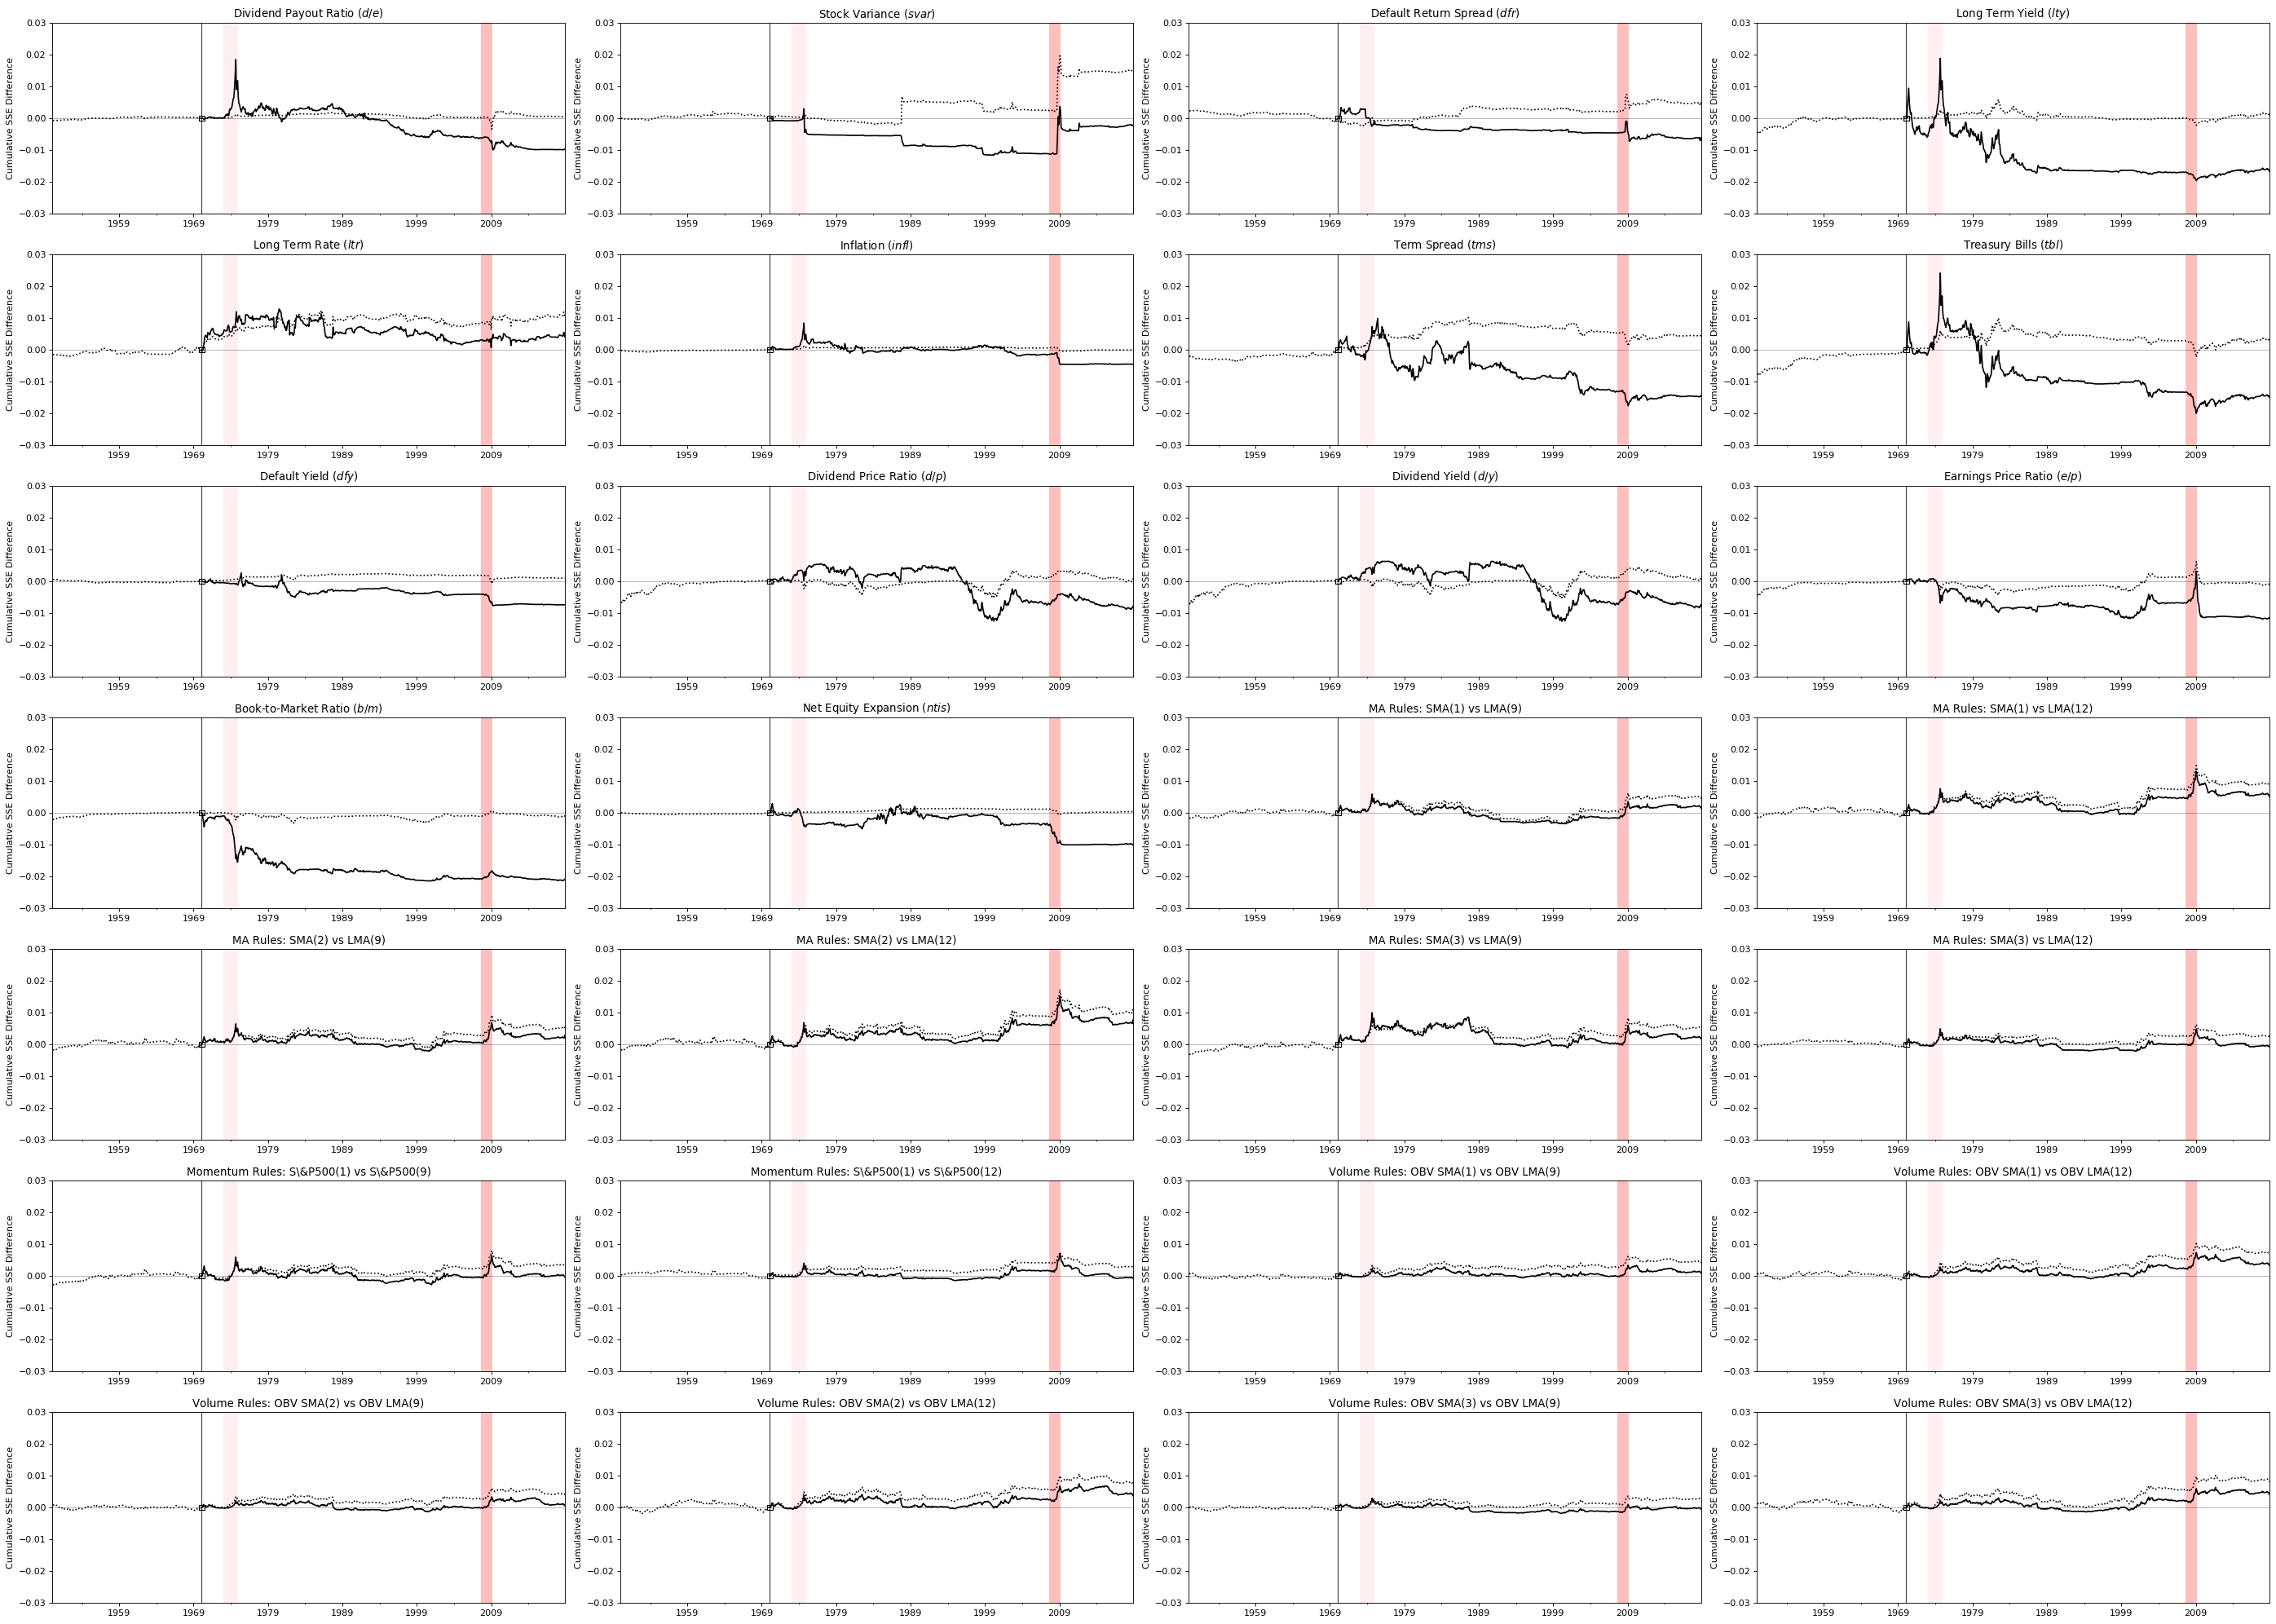

In [17]:
plot_vars(dep_var, indep_vars, -0.03, 0.03)

## Forecast Combinations of Economic Variables on Equity Premium

In [18]:
def Pool_Avg(Y, Y_Hat):   
    """Compute the out-of-sample predictability statistics based on pooling average.    
    Args:
        Y : The dependant variable
        Y_Hat: The vector of predicted values based on expanding windows
    Returns:
        data: a data frame of the statistics of the out-of-sample tests
    """    
   
    # Create the benchmark using historical average
    #Y = np.asarray(Y)
    #Y_Hat = np.asarray(Y_Hat)
    
    # Preapre for the pooling average  
    Y_Hat_Mean = np.mean(Y_Hat,axis=1)
    Y_Hat_Median = np.median(Y_Hat,axis=1)      
    Y_Hat_TrimmedMean = stats.trim_mean(Y_Hat,0.1,axis=1)
    
    Y_Hat_Mean_T = np.mean(Y_Hat.clip(0,None),axis=1)
    Y_Hat_Median_T = np.median(Y_Hat.clip(0,None),axis=1)
    Y_Hat_TrimmedMean_T = stats.trim_mean(Y_Hat.clip(0,None),0.1,axis=1)

    # Combination forecast based on mean of various forecasts                
    OOS_R2_Pool_Mean, CE_Pool_Mean, dRMSE_Pool_Mean = oos_eval(Y, Y_Hat_Mean)
    OOS_R2_Pool_Mean_T, CE_Pool_Mean_T, dRMSE_Pool_Mean_T = oos_eval(Y, Y_Hat_Mean_T)

    # Combination forecast based on median of various forecasts                
    OOS_R2_Pool_Median, CE_Pool_Median, dRMSE_Pool_Median = oos_eval(Y, Y_Hat_Median)
    OOS_R2_Pool_Median_T, CE_Pool_Median_T, dRMSE_Pool_Median_T = oos_eval(Y, Y_Hat_Median_T)
    
    # Combination forecast based on trimmed median of various forecasts                
    OOS_R2_Pool_TrimmedMean, CE_Pool_TrimmedMean, dRMSE_Pool_TrimmedMean = oos_eval(Y, Y_Hat_TrimmedMean)
    OOS_R2_Pool_TrimmedMean_T, CE_Pool_TrimmedMean_T, dRMSE_Pool_TrimmedMean_T = oos_eval(Y, Y_Hat_TrimmedMean_T)

    # Return the table
    data = pd.DataFrame({'$R_{OS}^2$ (Pooled Mean)':[OOS_R2_Pool_Mean, OOS_R2_Pool_Mean_T],
                         '$\Delta CEV$ (Pooled Mean)':[CE_Pool_Mean-CE_Hist, CE_Pool_Mean_T-CE_Hist],
                         '$\Delta RMSE$ (Pooled Mean)':[dRMSE_Pool_Mean, dRMSE_Pool_Mean_T],
                         '$R_{OS}^2$ (Pooled Median)':[OOS_R2_Pool_Median, OOS_R2_Pool_Median_T],
                         '$\Delta CEV$ (Pooled Median)':[CE_Pool_Median-CE_Hist, CE_Pool_Median_T-CE_Hist],
                         '$\Delta RMSE$ (Pooled Median)':[dRMSE_Pool_Median, dRMSE_Pool_Median_T],
                         '$R_{OS}^2$ (Trimmed Mean)':[OOS_R2_Pool_TrimmedMean, OOS_R2_Pool_TrimmedMean_T],
                         '$\Delta CEV$ (Trimmed Mean)':[CE_Pool_TrimmedMean-CE_Hist, CE_Pool_TrimmedMean_T-CE_Hist],
                         '$\Delta RMSE$ (Trimmed Mean)':[dRMSE_Pool_TrimmedMean, dRMSE_Pool_TrimmedMean_T]},
                        index=['Combination','Combination (Truncated)'])*100
    
    return data

In [19]:
def avg_cum_sse(df, Y_Hat, dep_var, window):
    
    # Preapre for the pooling average  
    Y_Hat_Mean = np.asarray(np.mean(Y_Hat,axis=1))
    Y_Hat_Median = np.asarray(np.median(Y_Hat,axis=1))
    Y_Hat_TrimmedMean = np.asarray(stats.trim_mean(Y_Hat,0.1,axis=1))

    # Make sure we don't modify the input
    df = df.copy()
    
    # I. In sample
    # I.1 Historical mean model
    avg = df[dep_var].mean()
    df['IS_Error_Mean'] = df[dep_var] - avg
   
    # I.2 Forecast combinations
    df['IS_Error_OLS_Mean'] = df[dep_var] - Y_Hat_Mean
    df['IS_Error_OLS_Median'] = df[dep_var] - Y_Hat_Median
    df['IS_Error_OLS_TrimmedMean'] = df[dep_var] - Y_Hat_TrimmedMean
    
    # II. Out of sample
    # II.1 Historical mean model
    df['OOS_Pred_Mean'] = df.expanding(min_periods=window)[dep_var].mean().shift()
    df['OOS_Error_Mean'] = df[dep_var] - df['OOS_Pred_Mean']
    
    # II.2 OLS
    # II.2 Forecast combinations
    df['OOS_Error_OLS_Mean'] = df[dep_var] - Y_Hat_Mean
    df['OOS_Error_OLS_Median'] = df[dep_var] - Y_Hat_Median
    df['OOS_Error_OLS_TrimmedMean'] = df[dep_var] - Y_Hat_TrimmedMean
    
    # Cumulative SSE differences
    df['IS_SSE_Mean'] = ((df['IS_Error_Mean'] ** 2).cumsum() - (df['IS_Error_OLS_Mean'] ** 2).cumsum())
    df['IS_SSE_Median'] = ((df['IS_Error_Mean'] ** 2).cumsum() - (df['IS_Error_OLS_Median'] ** 2).cumsum())
    df['IS_SSE_TrimmedMean'] = ((df['IS_Error_Mean'] ** 2).cumsum() - (df['IS_Error_OLS_TrimmedMean'] ** 2).cumsum())
    df['OOS_SSE_Mean'] = ((df['OOS_Error_Mean'] ** 2).cumsum() - (df['OOS_Error_OLS_Mean'] ** 2).cumsum())
    df['OOS_SSE_Median'] = ((df['OOS_Error_Mean'] ** 2).cumsum() - (df['OOS_Error_OLS_Median'] ** 2).cumsum())
    df['OOS_SSE_TrimmedMean'] = ((df['OOS_Error_Mean'] ** 2).cumsum() - (df['OOS_Error_OLS_TrimmedMean'] ** 2).cumsum())
    
    return df

In [20]:
def plot_avg(Y_Hat, dep_var, ymin, ymax):
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 4), dpi=100)
    
    dfplot = df_monthly['1950-01-01':]
    
    dfplot_avg = avg_cum_sse(dfplot, Y_Hat, dep_var, window=20*12)
    dfplot_mean = dfplot_avg[['IS_SSE_Mean','OOS_SSE_Mean']]
    dfplot_median = dfplot_avg[['IS_SSE_Median','OOS_SSE_Median']]
    dfplot_trimmedmean = dfplot_avg[['IS_SSE_TrimmedMean','OOS_SSE_TrimmedMean']]
    dfplot_mean.columns = ['IS_SSE','OOS_SSE']
    dfplot_median.columns = ['IS_SSE','OOS_SSE']
    dfplot_trimmedmean.columns = ['IS_SSE','OOS_SSE']

    plot_cum_sse(dfplot_mean, axes[0], title='Mean',
                 add_oil_shock=True,
                 add_GFC=True,
                 xlim=datetime(1970, 1, 1),
                 ylim=(ymin, ymax))

    plot_cum_sse(dfplot_median, axes[1], title='Median',
                 add_oil_shock=True,
                 add_GFC=True,
                 xlim=datetime(1970, 1, 1),
                 ylim=(ymin, ymax))

    plot_cum_sse(dfplot_trimmedmean, axes[2], title='Trimmed Mean',
                 add_oil_shock=True,
                 add_GFC=True,
                 xlim=datetime(1970, 1, 1),
                 ylim=(ymin, ymax))

    fig.tight_layout()
    
    fig.savefig(dep_var+'_'+str(np.shape(Y_Hat)[1])+'_Avg_Monthly_CumSSEDiff.pdf', dpi=500)

In [21]:
Pool_Avg(df[dep_var], df_pred_econ[indep_vars_econ])

,$R_{OS}^2$ (Pooled Mean),$\Delta CEV$ (Pooled Mean),$\Delta RMSE$ (Pooled Mean),$R_{OS}^2$ (Pooled Median),$\Delta CEV$ (Pooled Median),$\Delta RMSE$ (Pooled Median),$R_{OS}^2$ (Trimmed Mean),$\Delta CEV$ (Trimmed Mean),$\Delta RMSE$ (Trimmed Mean)
Combination,0.709,0.157,0.375,0.426,0.050,0.225,0.576,0.119,0.305
Combination (Truncated),0.445,0.032,0.235,0.401,0.043,0.212,0.457,0.045,0.242


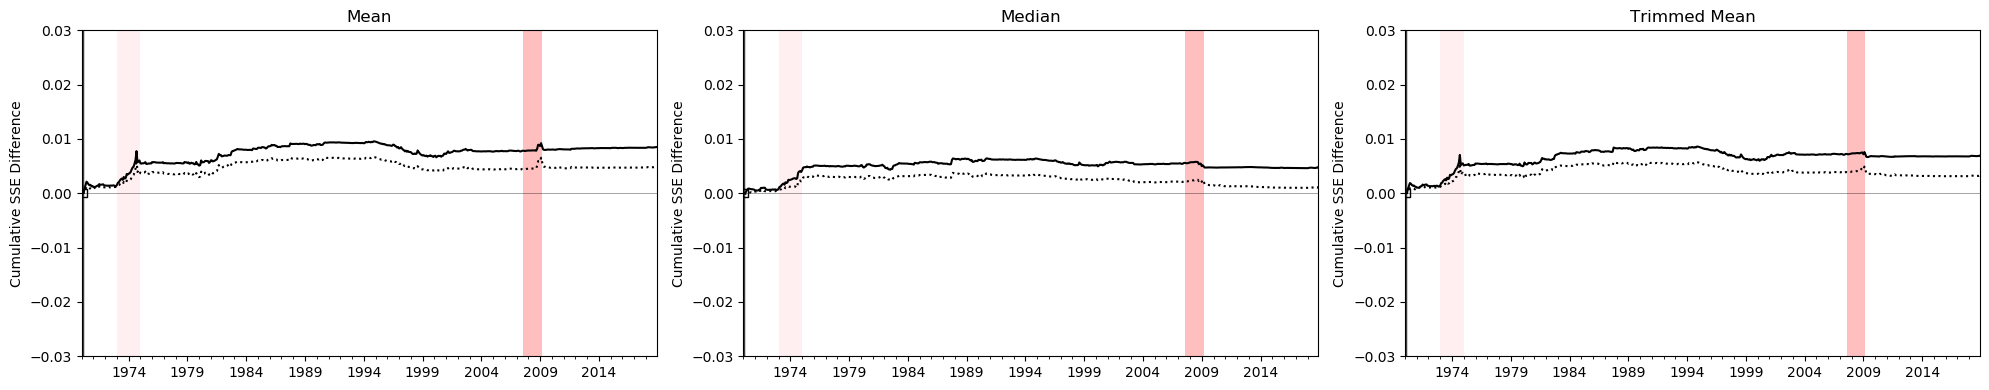

In [22]:
plot_avg(df_pred_econ[indep_vars_econ], dep_var, -0.03, 0.03)

## Forecast Combinations of Economic and Technical Variables on Equity Premium

In [23]:
Pool_Avg(df[dep_var], df_pred_all[indep_vars])

,$R_{OS}^2$ (Pooled Mean),$\Delta CEV$ (Pooled Mean),$\Delta RMSE$ (Pooled Mean),$R_{OS}^2$ (Pooled Median),$\Delta CEV$ (Pooled Median),$\Delta RMSE$ (Pooled Median),$R_{OS}^2$ (Trimmed Mean),$\Delta CEV$ (Trimmed Mean),$\Delta RMSE$ (Trimmed Mean)
Combination,0.590,0.166,0.312,0.428,0.180,0.226,0.472,0.143,0.250
Combination (Truncated),0.486,0.124,0.257,0.435,0.182,0.230,0.483,0.139,0.256


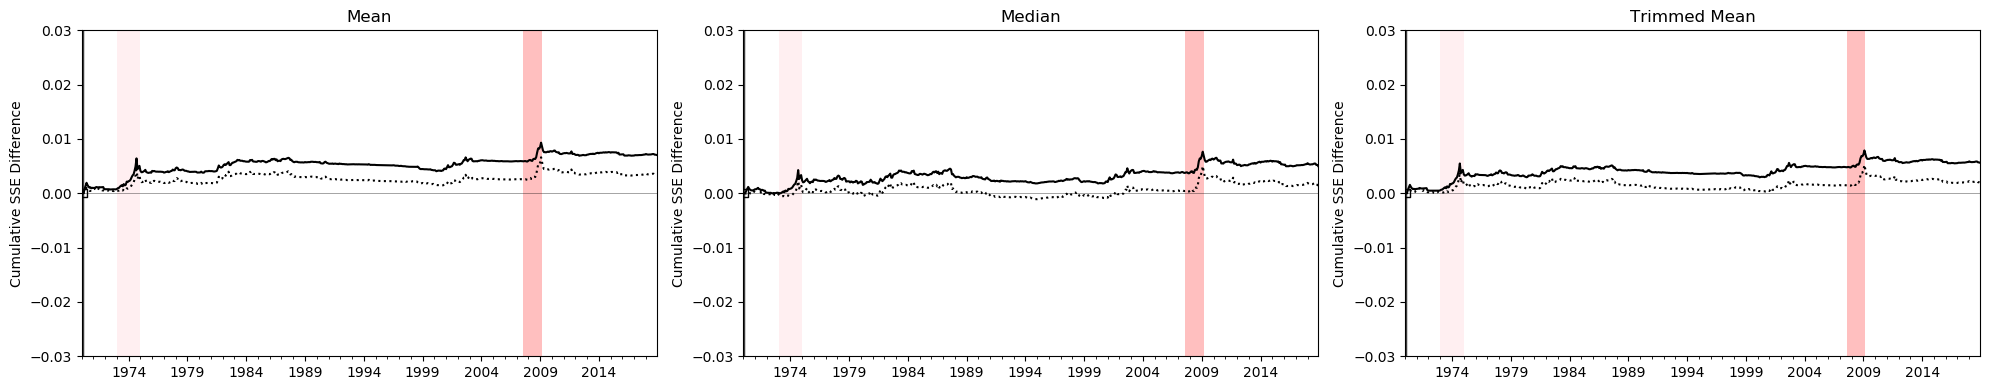

In [24]:
plot_avg(df_pred_all[indep_vars], dep_var, -0.03, 0.03)

## Extended Sum of Parts (ESOP) Approach and Forecast Combinations 

### OLS Forecast and Forecast Combinations of Economic Variables on Price/Earnings Multiple

In [25]:
# Create a prediction matrix from different predictive regressions
# Multiple predictive regression using all predictive variables excluding DE and tms
df_pred_PEG = pd.DataFrame(pred_from_OLS(df[indep_vars_econ], df['PEG'], M))
df_pred_PEG.columns = ['All']
# Simple predictive regressions using one predictive variable at a time
for indep_var in tqdm(indep_vars_econ):
    df_pred_PEG[indep_var] = pred_from_OLS(df[indep_var], df['PEG'], M)
df_pred_PEG = df_pred_PEG.set_index(df.index)

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


In [26]:
# The difference between PEG and predicted PEG is reasonable
np.linalg.norm(np.asarray(df['PEG'])[241:] - np.asarray(df_pred_PEG['All'])[241:])

1.5633247285816332

In [27]:
# Create the Table for the in- and out-of-sample performance
pd.options.display.float_format = '{:.3f}'.format
# Get rid of d/e and tms to avoid perfect multicollinearity
data_PEG = GW(df[indep_vars_econ], df['PEG'], df_pred_PEG['All']) 
data_PEG.rename(index={data_PEG.index[0]:'All'},inplace=True) 
for indep_var in indep_vars_econ:
    x = GW(df[indep_var], df['PEG'], df_pred_PEG[indep_var])
    data_PEG = data_PEG.append(x)    
data_PEG

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
All,12.618,9.753,5.679,5.384,-1.746,0.032,4.637,4.393
DE,0.005,0.005,-2.158,-1.718,-1.881,-0.750,-1.727,-1.377
svar,3.397,3.391,0.313,1.159,-1.203,-0.495,0.253,0.936
dfr,0.369,0.383,-0.087,-0.158,-0.321,-0.297,-0.070,-0.127
lty,0.009,0.009,-0.739,0.010,-1.214,-0.281,-0.594,0.008
ltr,1.321,1.500,0.701,0.984,-0.598,-0.376,0.565,0.794
infl,0.639,0.848,0.319,0.402,-0.463,-0.334,0.257,0.324
tms,0.063,-0.122,-0.798,-0.881,-0.563,-0.548,-0.641,-0.708
tbl,0.001,0.001,-0.960,-0.258,-1.484,-0.510,-0.771,-0.207
dfy,3.601,4.208,2.975,3.062,-0.715,-0.694,2.413,2.483


In [28]:
Pool_Avg(df['PEG'], df_pred_PEG[indep_vars_econ])

,$R_{OS}^2$ (Pooled Mean),$\Delta CEV$ (Pooled Mean),$\Delta RMSE$ (Pooled Mean),$R_{OS}^2$ (Pooled Median),$\Delta CEV$ (Pooled Median),$\Delta RMSE$ (Pooled Median),$R_{OS}^2$ (Trimmed Mean),$\Delta CEV$ (Trimmed Mean),$\Delta RMSE$ (Trimmed Mean)
Combination,1.155,-0.299,0.932,0.379,-0.160,0.305,1.102,-0.239,0.889
Combination (Truncated),0.971,-0.400,0.783,0.339,-0.174,0.273,0.937,-0.313,0.756


100%|██████████| 5/5 [01:34<00:00, 18.97s/it]


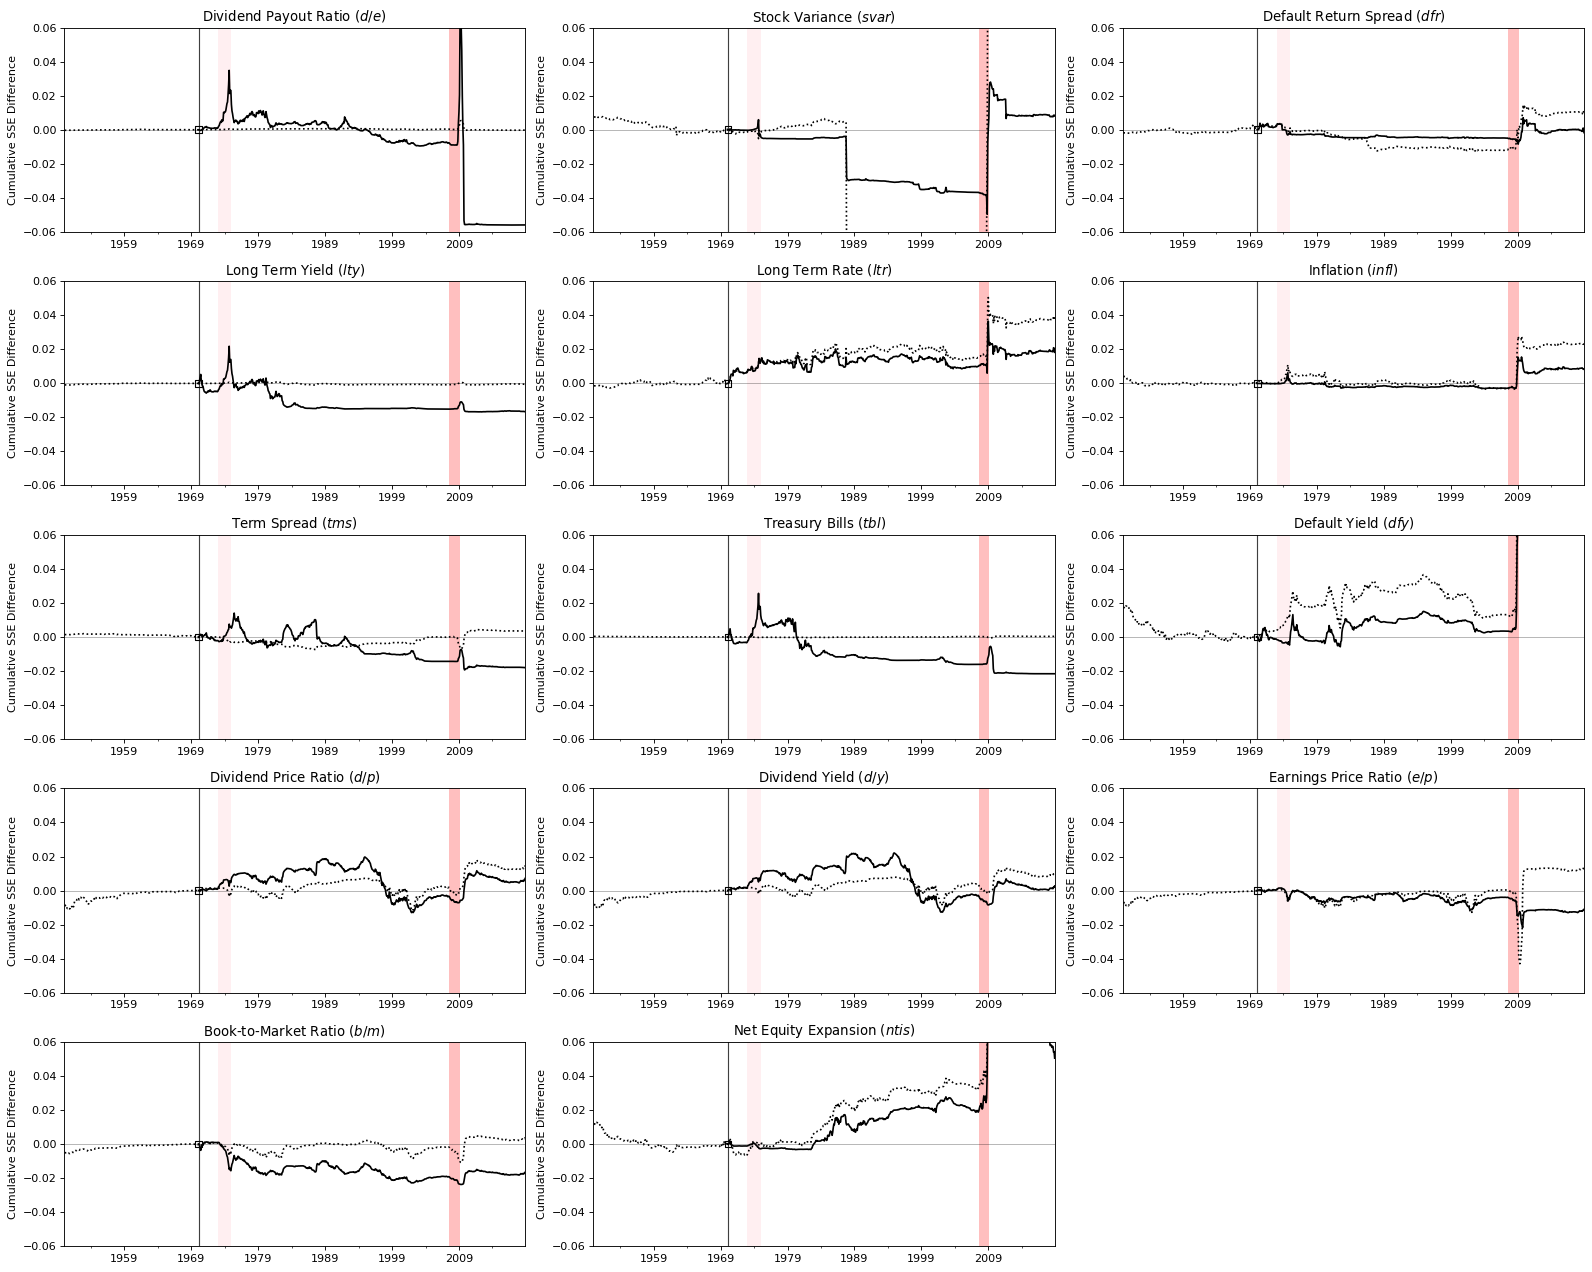

In [29]:
plot_vars('PEG', indep_vars_econ, -0.06, 0.06)

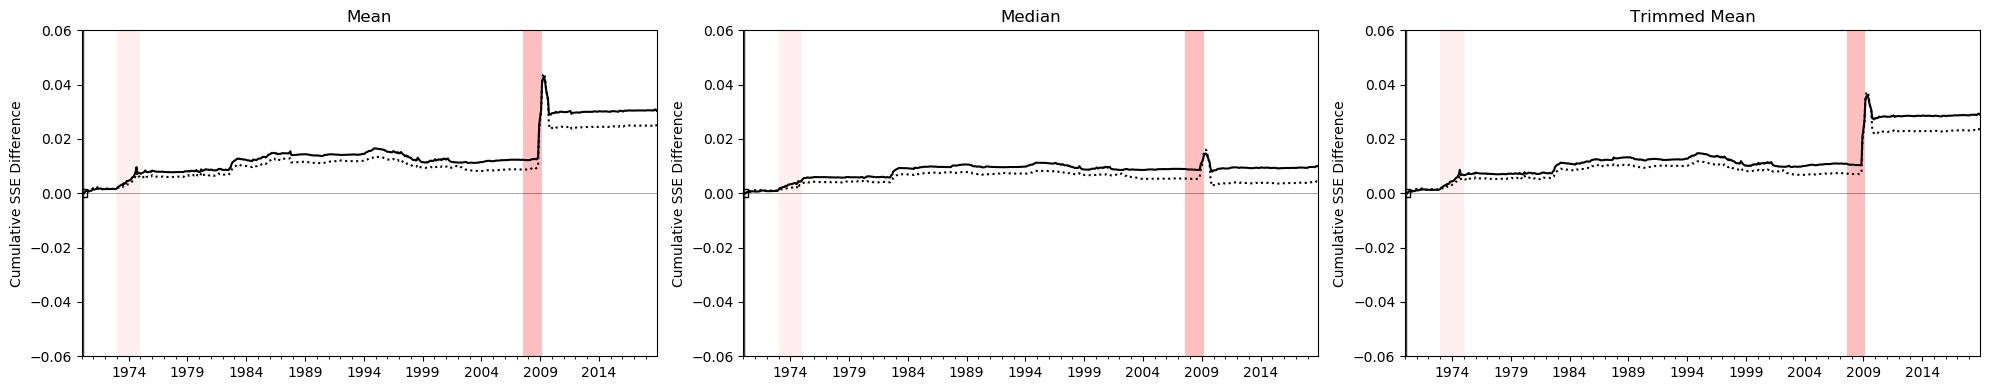

In [30]:
plot_avg(df_pred_PEG[indep_vars_econ], 'PEG', -0.06, 0.06)

### OLS Forecast and Forecast Combinations of Economic and Technical Variables on Earnings Growth

In [31]:
# Create a prediction matrix from different predictive regressions
# Multiple predictive regression using all predictive variables excluding DE and tms
df_pred_EG = pd.DataFrame(pred_from_OLS(df[indep_vars], df['EG'], M))
df_pred_EG.columns = ['All']
# Simple predictive regressions using one predictive variable at a time
for indep_var in tqdm(indep_vars):
    df_pred_EG[indep_var] = pred_from_OLS(df[indep_var], df['EG'], M)
df_pred_EG = df_pred_EG.set_index(df.index)

100%|██████████| 28/28 [00:10<00:00,  2.72it/s]


In [32]:
# The difference between EG and predicted EG is reasonable
np.linalg.norm(np.asarray(df['EG'])[241:] - np.asarray(df_pred_EG['All'])[241:])

1.2253025008106884

In [33]:
# Create the Table for the in- and out-of-sample performance
pd.options.display.float_format = '{:.3f}'.format
# Get rid of d/e and tms to avoid perfect multicollinearity
data_EG = GW(df[indep_vars], df['EG'], df_pred_EG['All']) 
data_EG.rename(index={data_EG.index[0]:'All'},inplace=True) 
for indep_var in indep_vars:
    x = GW(df[indep_var], df['EG'], df_pred_EG[indep_var])
    data_EG = data_EG.append(x)    
data_EG

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
All,23.852,6.392,14.496,3.501,-856.737,0.649,9.980,2.340
DE,0.002,0.002,-2.913,0.201,-32.073,0.286,-1.916,0.133
svar,11.429,0.665,8.154,0.456,-206.072,0.456,5.517,0.302
dfr,1.397,0.287,0.662,0.777,-0.308,-0.049,0.440,0.516
lty,0.001,0.001,-0.123,-0.112,-0.144,-0.140,-0.081,-0.074
ltr,0.441,-0.273,-0.413,-0.677,-0.025,0.015,-0.273,-0.448
infl,1.182,-0.495,0.625,-0.190,-0.579,0.010,0.415,-0.126
tms,0.572,0.624,0.183,0.232,-0.126,-0.103,0.121,0.154
tbl,0.137,0.140,-0.210,-0.072,-0.172,-0.103,-0.139,-0.047
dfy,4.805,-0.794,3.527,0.196,-26.373,0.419,2.358,0.130


In [34]:
Pool_Avg(df['EG'], df_pred_EG[indep_vars])

,$R_{OS}^2$ (Pooled Mean),$\Delta CEV$ (Pooled Mean),$\Delta RMSE$ (Pooled Mean),$R_{OS}^2$ (Pooled Median),$\Delta CEV$ (Pooled Median),$\Delta RMSE$ (Pooled Median),$R_{OS}^2$ (Trimmed Mean),$\Delta CEV$ (Trimmed Mean),$\Delta RMSE$ (Trimmed Mean)
Combination,2.279,-0.239,1.518,2.517,0.564,1.678,2.027,0.413,1.350
Combination (Truncated),1.335,0.243,0.887,1.876,0.495,1.249,1.416,0.327,0.941


100%|██████████| 7/7 [03:01<00:00, 25.87s/it]


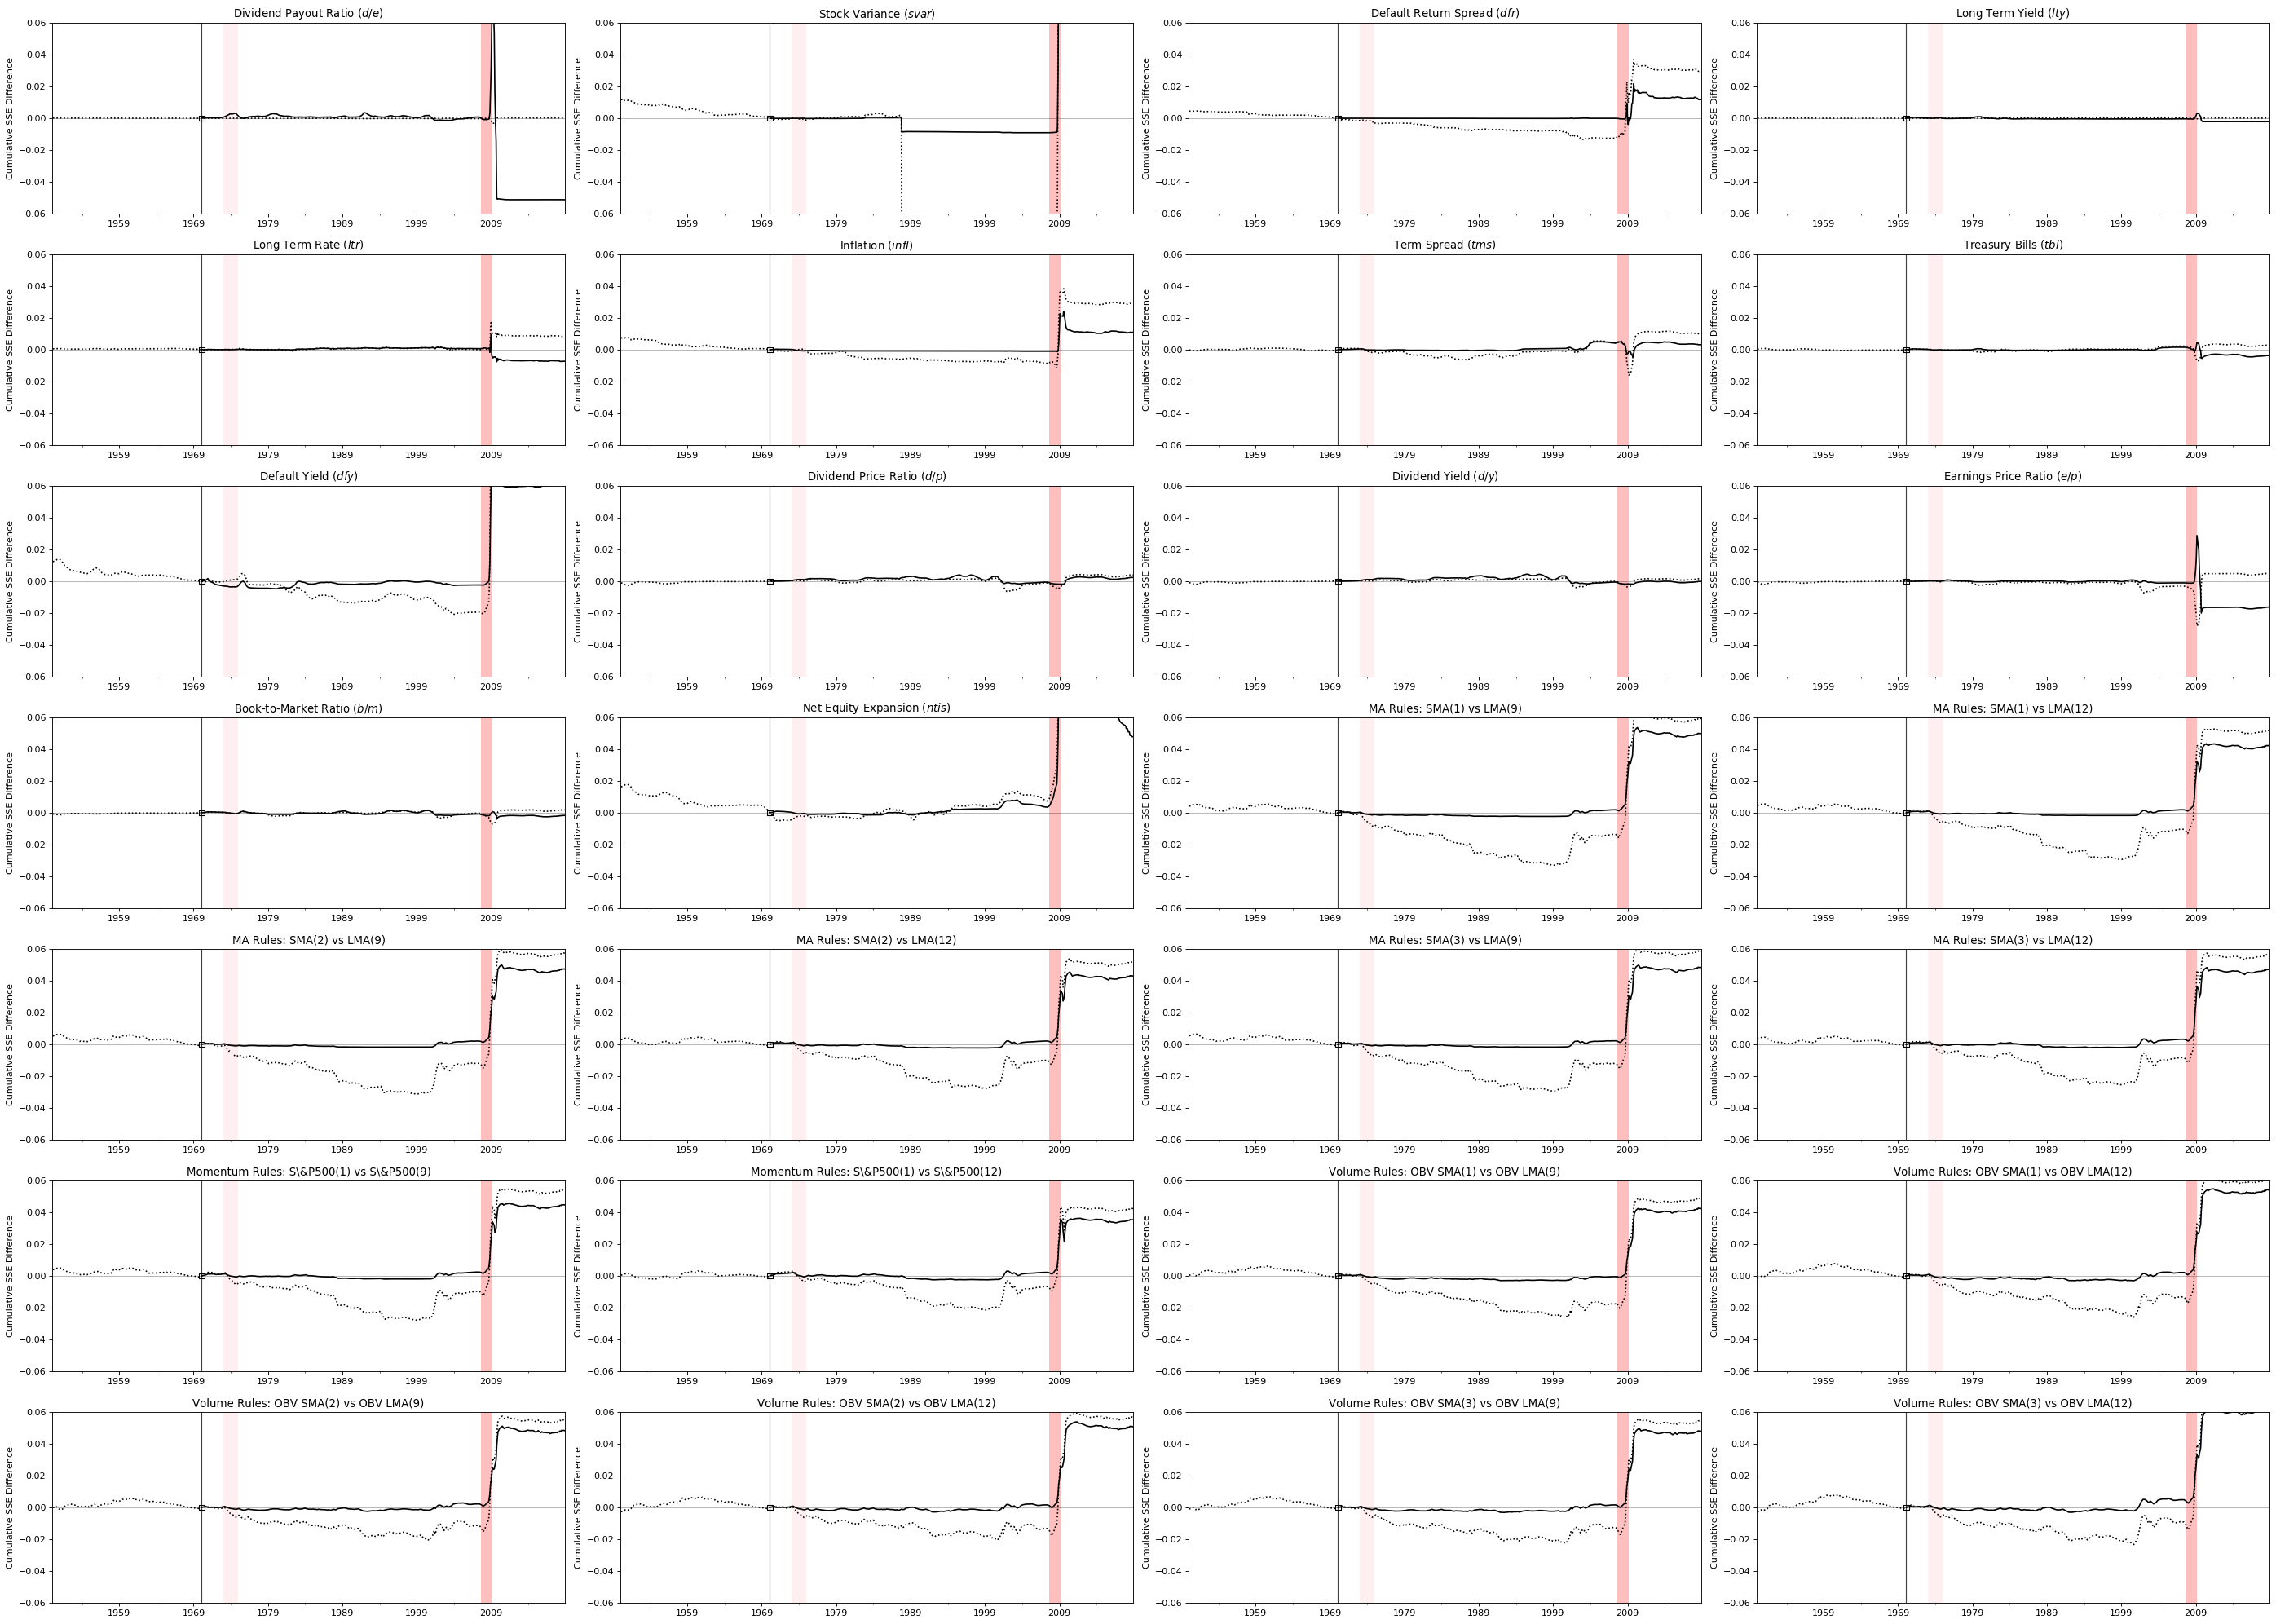

In [35]:
plot_vars('EG', indep_vars, -0.06, 0.06)

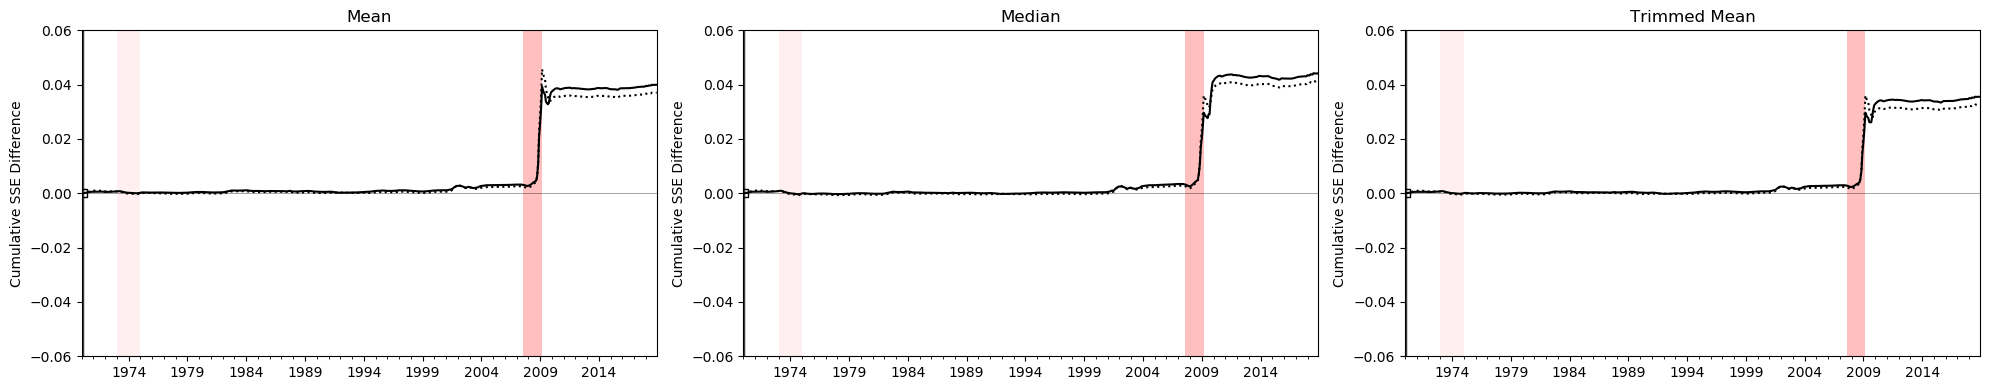

In [36]:
plot_avg(df_pred_EG[indep_vars], 'EG', -0.06, 0.06)

### ESOP

In [37]:
df_pred_ESOP = pd.DataFrame((df_pred_EG['All'] + df_pred_PEG['All'] + df['DP_SOP']-df['Rfree'].shift()))
df_pred_ESOP.columns = ['All']
df_pred_ESOP['Pooled Mean'] = (np.mean(df_pred_PEG[[x for x in indep_vars_econ]],axis=1) 
                                    + np.mean(df_pred_EG[[x for x in indep_vars]],axis=1) + df['DP_SOP'] - df['Rfree'].shift())
df_pred_ESOP['Pooled Median'] = (np.median(df_pred_PEG[[x for x in indep_vars_econ]],axis=1) 
                                    + np.median(df_pred_EG[[x for x in indep_vars]],axis=1) + df['DP_SOP'] - df['Rfree'].shift())
df_pred_ESOP['Trimmed Mean'] = (stats.trim_mean(df_pred_PEG[[x for x in indep_vars_econ]],0.1,axis=1) 
                                    + stats.trim_mean(df_pred_EG[[x for x in indep_vars]],0.1,axis=1) + df['DP_SOP'] - df['Rfree'].shift())

In [38]:
pd.options.display.float_format = '{:.3f}'.format
data_ESOP = pd.DataFrame(oos_eval(df[dep_var], df_pred_ESOP['All']), index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])
data_ESOP.columns = ['All']
data_ESOP['Pooled Mean'] = oos_eval(df[dep_var], df_pred_ESOP['Pooled Mean'])
data_ESOP['Pooled Median'] = oos_eval(df[dep_var], df_pred_ESOP['Pooled Median'])
data_ESOP['Trimmed Mean'] = oos_eval(df[dep_var], df_pred_ESOP['Trimmed Mean'])
data_ESOP.transpose()*100

,$R_{OS}^2$,$\Delta CEV$,$\Delta RMSE$
All,-1.784,-1.331,-0.938
Pooled Mean,1.380,0.470,0.731
Pooled Median,1.396,0.521,0.740
Trimmed Mean,1.294,0.474,0.686


## Machine Learning (Supervised Learning) and ESOP

### Ridge Regression for Equity Premium

In [39]:
def pred_from_ridge(X, Y, alphas):
    
    X = np.asarray(X)
    pred_ridge = []

    for a in alphas: # iterating over alphas for solution path
        Y_Hat = np.full(len(Y), np.nan)
        for i in range(M+1,len(Y)):
            Y1 = Y[1:i]
            X1 = X[0:i-1]
            ridge = Ridge(alpha=a, normalize=True)
            ridge.fit(X1, Y1) # fit lasso for every alpha (along solution path)
            Y_Hat[i] = ridge.predict(X[i-1:i])
        pred_ridge.append(Y_Hat)

    pred_ridge = pd.DataFrame(pred_ridge).transpose()
    pred_ridge.index = df.index
    
    return pred_ridge

In [40]:
def ridge_stats(X, Y, Y_Hat, alphas):
    
    # Create the benchmark using historical average
    X = np.asarray(X)
    # X = sm.add_constant(X) 
    
    # I. In sample
    Y_1 = Y[1:]
    X_1 = X[0:len(Y)-1]
    
    stats = {}

    for i in tqdm(range(len(alphas))):

        Y_Hat_1 = Y_Hat[i]
        ridge = Ridge(alpha=alphas[i], normalize=True)
        ridge.fit(X_1, Y_1)
        
        # I.1 In-sample R^2 for OLS Model (non truncated)
        y1 = Y_1-np.mean(Y_1)
        e1 = Y_1-ridge.predict(X_1)
        IS_R2 = 1-np.sum(e1**2)/np.sum(y1**2)

        # I.2 In-sample R^2 for OLS Model (truncated)
        y1 = Y_1-np.mean(Y_1)
        e1 = Y_1-ridge.predict(X_1).clip(0,None)
        IS_R2_T = 1-np.sum(e1**2)/np.sum(y1**2)

        # II. Out of sample    
        # II.1 Forecast based on regression with expanding window                
        OOS_R2, CE, dRMSE = oos_eval(Y, Y_Hat_1)

        # II.2 Trunacated forecast based on regression with expanding window
        OOS_R2_T, CE_T, dRMSE_T = oos_eval(Y, Y_Hat_1.clip(0,None))

        stats[i] = [IS_R2, IS_R2_T, OOS_R2, OOS_R2_T, CE-CE_Hist, CE_T-CE_Hist, dRMSE, dRMSE_T]

    stats = pd.DataFrame(stats,index=['$R_{IS}^2$', '$R^2_{IS}$ (Truncated)', '$R^2_{OS}$', '$R^2_{OS}$ (Truncated)',
                                      '$\Delta CEV$', '$\Delta CEV$ (Truncated)', '$\Delta RMSE$', '$\Delta RMSE$ (Truncated)'])*100
    return stats.transpose()

In [41]:
n_alphas = 50 # alpha is penalty tuning parameter
alphas = np.logspace(-1, 1, n_alphas)

In [42]:
pred_ridge = pred_from_ridge(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], alphas)

In [43]:
ridgestat = ridge_stats(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], pred_ridge, alphas)

100%|██████████| 50/50 [00:00<00:00, 78.00it/s]


In [44]:
# Optimal alpha
opt = np.argmax(ridgestat['$R^2_{OS}$'])
alphas[opt]

1.3894954943731375

In [45]:
ridgestat[opt:opt+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
28,3.964,2.895,1.510,1.331,0.232,0.316,0.800,0.705


In [46]:
# The difference between ExRet and ridge prediction is reasonable
np.linalg.norm(np.asarray(df['ExRet'])[241:] - np.asarray(pred_ridge[opt])[241:])

1.0479316946661918

Note that the objective function of sklearn's Ridge regression is
$\sum_{i=1}^n (y_i-x_i'\beta)^2+\lambda \sum_{j=1}^p\beta_j^2$.

### Ridge Regression for ESOP on Equity Premium

#### Ridge Regression of Economic Variables on Price/Earnings Multiple (Max $R^2_{OS}$)

In [47]:
n_alphas = 50 # alpha is penalty tuning parameter
alphas = np.logspace(-8, 3, n_alphas)

In [48]:
alphas[0:5]

array([1.00000000e-08, 1.67683294e-08, 2.81176870e-08, 4.71486636e-08,
       7.90604321e-08])

In [49]:
pred_ridge_PEG = pred_from_ridge(df[indep_vars_econ], df['PEG'], alphas)

In [50]:
PEG_ridge_stats = ridge_stats(df[indep_vars_econ], df['PEG'], pred_ridge_PEG, alphas)

100%|██████████| 50/50 [00:00<00:00, 75.49it/s]


In [51]:
# Optimal alpha
opt_PEG = np.argmax(PEG_ridge_stats['$R^2_{OS}$'])
alphas[opt_PEG]

1e-08

In [52]:
PEG_ridge_stats[opt_PEG:opt_PEG+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
0,12.618,9.753,5.679,5.384,-1.746,0.032,4.637,4.393


In [53]:
# The difference between PEG and ridge prediction PEG is reasonable
np.linalg.norm(np.asarray(df['PEG'])[241:] - np.asarray(pred_ridge_PEG[opt_PEG])[241:])

1.5633247295526398

#### Ridge Regression of Economic and Technical Variables on Earnings Growth (Max $R^2_{OS}$)

In [54]:
pred_ridge_EG = pred_from_ridge(df[indep_vars], df['EG'], alphas)

In [55]:
EG_ridge_stats = ridge_stats(df[indep_vars], df['EG'], pred_ridge_EG, alphas)

100%|██████████| 50/50 [00:00<00:00, 74.83it/s]


In [56]:
# Optimal alpha
opt_EG = np.argmax(EG_ridge_stats['$R^2_{OS}$'])
alphas[opt_EG]

1e-08

In [57]:
EG_ridge_stats[opt_EG:opt_EG+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
0,23.852,6.392,14.496,3.501,-856.737,0.649,9.980,2.340


In [58]:
# The difference between EG and ridge prediction EG is reasonable
np.linalg.norm(np.asarray(df['EG'])[241:] - np.asarray(pred_ridge_EG[opt_EG])[241:])

1.225302500997786

#### Ridge Regression ESOP (Max $R^2_{OS}$)

In [59]:
data_ridge_ESOP = {}
for a in tqdm(range(len(alphas))):
    OOS_R2 = []
    for b in range(len(alphas)):
        x = oos_eval(df['ExRet'], pred_ridge_EG[a] + pred_ridge_PEG[b] + df['DP_SOP'] - df['Rfree'].shift())[0]*100
        OOS_R2.append(x)
    data_ridge_ESOP[a] = OOS_R2

100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


In [60]:
op1 = np.argmax(pd.DataFrame(data_ridge_ESOP))//50
op2 = np.argmax(pd.DataFrame(data_ridge_ESOP)[op1])

In [61]:
alphas[op1]

3.39322177189533

In [62]:
alphas[op2]

2.0235896477251556

In [63]:
pd.options.display.float_format = '{:.3f}'.format
data_ridge_ESOP = pd.DataFrame(oos_eval(df['ExRet'], pred_ridge_EG[op1] + pred_ridge_PEG[op2] + df['DP_SOP'] - df['Rfree'].shift()), 
                               index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])
data_ridge_ESOP.columns = ['ESOP Ridge (optimum lambda)']
data_ridge_ESOP['ESOP Ridge (component lambda)'] = oos_eval(df['ExRet'], pred_ridge_EG[opt_EG] + pred_ridge_PEG[opt_PEG] 
                                                                   + df['DP_SOP'] - df['Rfree'].shift())
data_ridge_ESOP.transpose()*100

,$R_{OS}^2$,$\Delta CEV$,$\Delta RMSE$
ESOP Ridge (optimum lambda),1.702,0.356,0.903
ESOP Ridge (component lambda),-1.784,-1.331,-0.938


#### Ridge Regression (Max $\Delta CEV$)

In [64]:
# Optimal alpha
opt_PEG_CEV = np.argmax(PEG_ridge_stats['$\Delta CEV$'])
alphas[opt_PEG_CEV]

44.984326689694534

In [65]:
PEG_ridge_stats[opt_PEG_CEV:opt_PEG_CEV+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
43,0.596,0.596,0.385,0.391,-0.213,-0.209,0.310,0.315


In [66]:
# Optimal alpha
opt_EG_CEV = np.argmax(EG_ridge_stats['$\Delta CEV$'])
alphas[opt_EG_CEV]

44.984326689694534

In [67]:
EG_ridge_stats[opt_EG_CEV:opt_EG_CEV+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
43,2.362,1.952,1.278,0.874,0.407,0.365,0.849,0.580


In [68]:
data_ridge_ESOP = {}
for a in tqdm(range(len(alphas))):
    OOS_R2 = []
    for b in range(len(alphas)):
        x = oos_eval(df['ExRet'], pred_ridge_EG[a] + pred_ridge_PEG[b] + df['DP_SOP'] - df['Rfree'].shift())[1]*100
        OOS_R2.append(x)
    data_ridge_ESOP[a] = OOS_R2

100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


In [69]:
op1_CEV = np.argmax(pd.DataFrame(data_ridge_ESOP))//50
op2_CEV = np.argmax(pd.DataFrame(data_ridge_ESOP)[op1_CEV])

In [70]:
alphas[op1_CEV]

9.540954763499924

In [71]:
alphas[op2_CEV]

9.540954763499924

In [72]:
pd.options.display.float_format = '{:.3f}'.format
data_ridge_ESOP = pd.DataFrame(oos_eval(df['ExRet'], pred_ridge_EG[op1_CEV] + pred_ridge_PEG[op2_CEV] + df['DP_SOP'] - df['Rfree'].shift()), 
                               index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])
data_ridge_ESOP.columns = ['ESOP Ridge (optimum lambda)']
data_ridge_ESOP['ESOP Ridge (component lambda)'] = oos_eval(df['ExRet'], pred_ridge_EG[opt_EG_CEV] + pred_ridge_PEG[opt_PEG_CEV] 
                                                                   + df['DP_SOP'] - df['Rfree'].shift())
data_ridge_ESOP.transpose()*100

,$R_{OS}^2$,$\Delta CEV$,$\Delta RMSE$
ESOP Ridge (optimum lambda),1.318,0.496,0.698
ESOP Ridge (component lambda),0.958,0.422,0.507


### Lasso Regression for Equity Premium

In [73]:
def pred_from_lasso(X, Y, alphas):
    
    X = np.asarray(X)
    pred_lasso = []

    for a in alphas: # iterating over alphas for solution path
        Y_Hat = np.full(len(Y), np.nan)
        for i in range(M+1,len(Y)):
            Y1 = Y[1:i]
            X1 = X[0:i-1]
            lasso = Lasso(alpha=a, normalize=True)
            lasso.fit(X1, Y1) # fit lasso for every alpha (along solution path)
            Y_Hat[i] = lasso.predict(X[i-1:i])
        pred_lasso.append(Y_Hat)

    pred_lasso = pd.DataFrame(pred_lasso).transpose()
    pred_lasso.index = df.index
    
    return pred_lasso

In [74]:
def lasso_stats(X, Y, Y_Hat, alphas):
    
    # Create the benchmark using historical average
    X = np.asarray(X)
    # X = sm.add_constant(X) 
    
    # I. In sample
    Y_1 = Y[1:]
    X_1 = X[0:len(Y)-1]
    
    stats = {}

    for i in tqdm(range(len(alphas))):

        Y_Hat_1 = Y_Hat[i]
        lasso = Lasso(alpha=alphas[i], normalize=True)
        lasso.fit(X_1, Y_1)
        
        # I.1 In-sample R^2 for OLS Model (non truncated)
        y1 = Y_1-np.mean(Y_1)
        e1 = Y_1-lasso.predict(X_1)
        IS_R2 = 1-np.sum(e1**2)/np.sum(y1**2)

        # I.2 In-sample R^2 for OLS Model (truncated)
        y1 = Y_1-np.mean(Y_1)
        e1 = Y_1-lasso.predict(X_1).clip(0,None)
        IS_R2_T = 1-np.sum(e1**2)/np.sum(y1**2)

        # II. Out of sample    
        # II.1 Forecast based on regression with expanding window                
        OOS_R2, CE, dRMSE = oos_eval(Y, Y_Hat_1)

        # II.2 Trunacated forecast based on regression with expanding window
        OOS_R2_T, CE_T, dRMSE_T = oos_eval(Y, Y_Hat_1.clip(0,None))

        stats[i] = [IS_R2, IS_R2_T, OOS_R2, OOS_R2_T, CE-CE_Hist, CE_T-CE_Hist, dRMSE, dRMSE_T]

    stats = pd.DataFrame(stats,index=['$R_{IS}^2$', '$R^2_{IS}$ (Truncated)', '$R^2_{OS}$', '$R^2_{OS}$ (Truncated)',
                                      '$\Delta CEV$', '$\Delta CEV$ (Truncated)', '$\Delta RMSE$', '$\Delta RMSE$ (Truncated)'])*100
    return stats.transpose()

In [75]:
n_alphas = 50 # alpha is penalty tuning parameter
alphas = np.logspace(-5, 1, n_alphas)

In [76]:
pred_lasso = pred_from_lasso(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], alphas)

In [77]:
lassostat = lasso_stats(df[[x for x in indep_vars if x not in('DE','tms')]], df[dep_var], pred_lasso, alphas)

100%|██████████| 50/50 [00:00<00:00, 72.90it/s]


In [78]:
# Optimal alpha
opt_lasso = np.argmax(lassostat['$R^2_{OS}$'])
alphas[opt_lasso]

9.540954763499944e-05

In [79]:
opt_lasso

8

In [80]:
lassostat[opt_lasso:opt_lasso+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
8,2.148,1.688,1.259,1.034,0.007,0.267,0.667,0.547


### Lasso Regression for ESOP on Equity Premium

#### Lasso Regression of Economic Variables on Price/Earnings Multiple (Max $R^2_{OS}$)

In [81]:
n_alphas = 50 # alpha is penalty tuning parameter
alphas = np.logspace(-5, 5, n_alphas)

In [82]:
pred_lasso_PEG = pred_from_lasso(df[indep_vars_econ], df['PEG'], alphas)

In [83]:
PEG_lasso_stats = lasso_stats(df[indep_vars_econ], df['PEG'], pred_lasso_PEG, alphas)

100%|██████████| 50/50 [00:00<00:00, 99.01it/s]


In [84]:
# Optimal alpha
opt_lasso_PEG = np.argmax(PEG_lasso_stats['$R^2_{OS}$'])
alphas[opt_lasso_PEG]

1e-05

In [85]:
PEG_lasso_stats[opt_lasso_PEG:opt_lasso_PEG+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
0,11.907,8.927,4.989,4.915,-1.152,-0.017,4.067,4.006


#### Lasso Regression of Economic and Technical Variables on Earnings Growth (Max $R^2_{OS}$)

In [86]:
pred_lasso_EG = pred_from_lasso(df[indep_vars], df['EG'], alphas)

In [87]:
EG_lasso_stats = lasso_stats(df[indep_vars], df['EG'], pred_lasso_EG, alphas)

100%|██████████| 50/50 [00:00<00:00, 63.88it/s]


In [88]:
# Optimal alpha
opt_lasso_EG = np.argmax(EG_lasso_stats['$R^2_{OS}$'])
alphas[opt_lasso_EG]

1e-05

In [89]:
EG_lasso_stats[opt_lasso_EG:opt_lasso_EG+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
0,23.165,6.122,13.641,3.158,-732.359,0.608,9.369,2.109


#### Lasso Regression ESOP (Max $R^2_{OS}$)

In [90]:
data_lasso_ESOP = {}
for a in tqdm(range(len(alphas))):
    OOS_R2 = []
    for b in range(len(alphas)):
        x = oos_eval(df['ExRet'], pred_lasso_EG[a] + pred_lasso_PEG[b] + df['DP_SOP'] - df['Rfree'].shift())[0]*100
        OOS_R2.append(x)
    data_lasso_ESOP[a] = OOS_R2

100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


In [91]:
op1_lasso = np.argmax(pd.DataFrame(data_lasso_ESOP))//50
op2_lasso = np.argmax(pd.DataFrame(data_lasso_ESOP)[op1_lasso])

In [92]:
alphas[op1_lasso]

0.0002682695795279727

In [93]:
alphas[op2_lasso]

0.0002682695795279727

In [94]:
pd.options.display.float_format = '{:.3f}'.format
data_lasso_ESOP = pd.DataFrame(oos_eval(df['ExRet'], pred_lasso_EG[op1_lasso] + pred_lasso_PEG[op2_lasso] + df['DP_SOP'] - df['Rfree'].shift()), 
                               index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])
data_lasso_ESOP.columns = ['ESOP Lasso (optimum lambda)']
data_lasso_ESOP['ESOP Lasso (component lambda)'] = oos_eval(df['ExRet'], pred_lasso_EG[opt_lasso_EG] + pred_lasso_PEG[opt_lasso_PEG] 
                                                                   + df['DP_SOP'] - df['Rfree'].shift())
data_lasso_ESOP.transpose()*100

,$R_{OS}^2$,$\Delta CEV$,$\Delta RMSE$
ESOP Lasso (optimum lambda),0.647,-0.005,0.342
ESOP Lasso (component lambda),-1.287,-1.020,-0.677


#### Lasso Regression (Max $\Delta CEV$)

In [95]:
# Optimal alpha
opt_lasso_PEG_CEV = np.argmax(PEG_lasso_stats['$\Delta CEV$'])
alphas[opt_lasso_PEG_CEV]

0.0006866488450042998

In [96]:
PEG_lasso_stats[opt_lasso_PEG_CEV:opt_lasso_PEG_CEV+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
9,0.000,0.000,0.001,0.005,-0.264,-0.263,0.001,0.004


In [97]:
# Optimal alpha
opt_lasso_EG_CEV = np.argmax(EG_lasso_stats['$\Delta CEV$'])
alphas[opt_lasso_EG_CEV]

0.0010985411419875584

In [98]:
EG_lasso_stats[opt_lasso_EG_CEV:opt_lasso_EG_CEV+1]

,$R_{IS}^2$,$R^2_{IS}$ (Truncated),$R^2_{OS}$,$R^2_{OS}$ (Truncated),$\Delta CEV$,$\Delta CEV$ (Truncated),$\Delta RMSE$,$\Delta RMSE$ (Truncated)
10,0.000,0.000,-0.001,-0.001,-0.201,-0.201,-0.000,-0.000


In [99]:
data_lasso_ESOP = {}
for a in tqdm(range(len(alphas))):
    OOS_R2 = []
    for b in range(len(alphas)):
        x = oos_eval(df['ExRet'], pred_lasso_EG[a] + pred_lasso_PEG[b] + df['DP_SOP'] - df['Rfree'].shift())[1]*100
        OOS_R2.append(x)
    data_lasso_ESOP[a] = OOS_R2

100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


In [100]:
op1_lasso_CEV = np.argmax(pd.DataFrame(data_lasso_ESOP))//50
op2_lasso_CEV = np.argmax(pd.DataFrame(data_lasso_ESOP)[op1_lasso_CEV])

In [101]:
alphas[op1_lasso_CEV]

0.0006866488450042998

In [102]:
alphas[op2_lasso_CEV]

0.0006866488450042998

In [103]:
pd.options.display.float_format = '{:.3f}'.format
data_lasso_ESOP = pd.DataFrame(oos_eval(df['ExRet'], pred_lasso_EG[op1_lasso_CEV] + pred_lasso_PEG[op2_lasso_CEV] + df['DP_SOP'] - df['Rfree'].shift()), 
                               index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])
data_lasso_ESOP.columns = ['ESOP Lasso (optimum lambda)']
data_lasso_ESOP['ESOP Lasso (component lambda)'] = oos_eval(df['ExRet'], pred_lasso_EG[opt_lasso_EG_CEV] + pred_lasso_PEG[opt_lasso_PEG_CEV] 
                                                                   + df['DP_SOP'] - df['Rfree'].shift())
data_lasso_ESOP.transpose()*100

,$R_{OS}^2$,$\Delta CEV$,$\Delta RMSE$
ESOP Lasso (optimum lambda),0.712,0.333,0.377
ESOP Lasso (component lambda),0.715,0.333,0.378


### Artificial Neural Networks

In [ ]:
from cntk.cntk_py import set_fixed_random_seed
set_fixed_random_seed(100)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KERAS_BACKEND'] = 'cntk'

import csv
import time
import pickle

import keras
from keras.layers import Dense
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from IPython.display import clear_output

import warnings; warnings.simplefilter('ignore')

In [ ]:
# Put the X and y variables in data frame for the regression, use D/Y as an example
y = df[dep_var]
x = df[indep_vars]

# Set seed
N = 240 # Initial length of estimation window, enough initial data for a reliable regression estimate at start 
# Divide your data into the Training Set and the Test Set 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
NN_dict = {}
for i in range(N,781,60):
    x_train, x_test, y_train, y_test = x[0:i], x[i:-1], y[1:i+1], y[i+1:]
    Hist_Mean = np.asarray(df[dep_var].expanding().mean().shift())
    OOS_MSE_Hist = np.sum((df[dep_var][i+1:]-Hist_Mean[i+1:])**2)/len(y_test)
    model = Sequential()
    model.add(Dense(30, activation = "relu", input_shape = (28,)))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss='mse',optimizer='Adam')
    NN = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test))
    NN_MSE = model.evaluate(x_test, y_test, verbose=0)
    Gain = (1-NN_MSE/OOS_MSE_Hist)*100
    NN_dict['Period: 0-'+ str(i)] = Gain


In [ ]:
data_ANN = pd.DataFrame(NN_dict,index=['Gain Ratio'])
data_ANN.transpose()

In [ ]:
# Compute the best estimate for eg, peg, and apply sum of part
#Put the X and y variables in data frame for the regression, use D/Y as an example
y = df['EG']
x = df[indep_vars]

P = 300 # Initial length of estimation window, enough initial data for a reliable regression estimate at start 
# Divide your data into the Training Set and the Test Set 
x_train, x_test, y_train, y_test = x[0:P], x[P:-1], y[1:P+1], y[P+1:]


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Build the model
model = Sequential()
model.add(Dense(50, activation = "relu", input_shape = (28,)))
model.add(Dense(1, activation = "sigmoid"))

# Use MSE for the loss
model.compile(loss='mse',optimizer='Adam')
# Train your model
NN = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test))
# make class predictions with the model
prediction_eg = model.predict(x_test)
#benchmark = y_test[0]-predictions[0]
#pred = predictions[0]        
#for i in range(len(predictions)):
    #diff = y_test[i]-predictions[i]
   #if abs(diff) > abs(benchmark):
        #diff = benchmark
        #pred = pred
    #else:
        #benchmark = diff
        #pred = predictions[i]    
#print (diff, pred)

In [ ]:
y = df['PEG']
x = df[indep_vars_econ]

# Divide your data into the Training Set and the Test Set 
x_train, x_test, y_train, y_test = x[0:P], x[P:-1], y[1:P+1], y[P+1:]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Build the model
model = Sequential()
model.add(Dense(50, activation = "relu", input_shape = (14,)))
model.add(Dense(1, activation = "sigmoid"))

# Use MSE for the loss
model.compile(loss='mse',optimizer='Adam')
# Train your model
NN = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test))
# make class predictions with the model
prediction_peg = model.predict(x_test)

In [ ]:
dp = df['DP_SOP'][P:-1]
rf = df['Rfree'][P:-1]
def sum_of_part(gm_hat, ge_hat, dp, rf):
    """Generate the SOP matrix"""
    Y_hat = np.full(len(gm_hat), np.nan)
    for i in range (len(gm_hat)):
        Y_hat[i] = gm_hat[i]+ge_hat[i]+ dp[i]-rf[i]
    return Y_hat

In [ ]:
y_hat = sum_of_part(prediction_peg, prediction_eg, dp, rf)
print (len(prediction_peg), len(prediction_eg), len(dp), len(rf))
ANN_ESOP = oos_eval(df['ExRet'][P+1:], y_hat)
data_ANN = pd.DataFrame(list(ANN_ESOP),index=['$R_{OS}^2$','$\Delta CEV$','$\Delta RMSE$'])*100
data_ANN.columns = ['ANN_ESOP']
data_ANN